# 1.  Librerías

## Básicas

In [1]:
# ============================================================
# Lectura de datos experimentales en formato ROOT (HEP)
# ============================================================
import uproot  # Acceso a árboles ROOT sin depender de ROOT/C++

In [2]:
# ============================================================
# Computación numérica y manipulación de datos
# ============================================================
import numpy as np
import pandas as pd

In [3]:
# ============================================================
# Visualización de datos y resultados
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ============================================================
# Manejo de estructuras irregulares (jagged arrays) típicas en HEP
# ============================================================
import awkward as ak # Operaciones vectorizadas sobre eventos con multiplicidad variable

In [5]:
# ============================================================
# Definición y manipulación de objetos físicos relativistas
# ============================================================
import vector  # Manejo de 4-vectores (pT, eta, phi, m) con reglas relativistas

In [6]:
# ============================================================
# Manejo del sistema de archivos y rutas
# ============================================================
from pathlib import Path  # Gestión de rutas de forma portable y robusta
import os                 # Interacción con el sistema operativo

In [7]:
# ============================================================
# Utilidades de preparación de datos para ML
# ============================================================
from sklearn.utils import shuffle  # Mezcla aleatoria de datos preservando correspondencia X–y

## Modelado, Validación y Evaluación

In [8]:
# ============================================================
# Modelo de Machine Learning basado en árboles
# ============================================================
from sklearn.ensemble import RandomForestClassifier  # Modelo base para análisis preliminar de importancia de variables

In [9]:
# ============================================================
# Utilidades para Validación y construcción de Pipelines
# ============================================================
from sklearn.model_selection import StratifiedKFold, cross_validate  # Validación cruzada estratificada para datasets desbalanceados
from sklearn.pipeline import Pipeline                              # Encadenamiento reproducible de preprocesamiento y modelo
from sklearn.preprocessing import StandardScaler                   # Escalado de variables numéricas (requerido por modelos sensibles a escala)


In [10]:
# ============================================================
# Modelado Base (Baseline)
# Modelos utilizados como referencia inicial de desempeño
# ============================================================

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Árboles: bagging y boosting como baselines no lineales
from sklearn.svm import SVC                                                        # SVM con kernel RBF como baseline no lineal sensible a escala
from sklearn.linear_model import LogisticRegression                                # Baseline lineal e interpretable

from lightgbm import LGBMClassifier                                                 # Baseline eficiente de boosting para comparación inicial
from xgboost import XGBClassifier                                                   # Baseline de boosting competitivo como referencia de desempeño

# ----- Instalaciones (de ser necesarias)
#!pip install lightgbm
#!pip install xgboost

## Optimización de Modelos

In [11]:
# ============================================================
# Optimización de Hiperparámetros y evaluación de modelos
# ============================================================
import optuna                                              # Optimización bayesiana de hiperparámetros
#from lightgbm import LGBMClassifier                         # Modelo base a optimizar (boosting de árboles)
from sklearn.model_selection import cross_val_score        # Evaluación de desempeño durante la optimización

# ----- Instalación (de ser necesaria)
#!pip install optuna

## Evaluación Final

In [12]:
# ============================================================
# Utilidades para predicción y evaluación fuera de muestra
# ============================================================

from sklearn.model_selection import cross_val_predict  # Predicciones out-of-fold para evaluación sin leakage

from sklearn.metrics import roc_curve, auc    # Curva ROC y área bajo la curva para evaluar separabilidad señal–fondo


In [13]:
# ============================================================
# Métricas para evaluación basada en precisión y recall
# ============================================================
from sklearn.metrics import precision_recall_curve, average_precision_score  # Curva Precision–Recall y Average Precision para evaluar pureza–eficiencia

In [14]:
# ============================================================
# Métricas de evaluación basadas en clasificación discreta
# ============================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Matriz de confusión para evaluar desempeño en un umbral fijo

In [15]:
# ============================================================
# Métricas para evaluación de calibración probabilística
# ============================================================
from sklearn.calibration import calibration_curve  # Curva de calibración para evaluar la calidad de las probabilidades predichas

# 2. Preprocesamiento de Datos [Formato]

## Formato ROOT -> DataFrame de Pandas

In [71]:
#import uproot
#import awkward as ak
#import pandas as pd

def procesar_muestra(filepath, sample_name, lep_max=2, jet_max=1, num_eventos=None):
    
    """
    Procesa un archivo ROOT de ATLAS Open Data y transforma los eventos
    en un DataFrame tabular apto para análisis de Machine Learning.

    Los objetos físicos (leptones y jets) se aplanan en columnas fijas,
    rellenando con ceros cuando la multiplicidad es menor al máximo definido.

    Parameters
    ----------
    filepath : str
    Ruta al archivo ROOT a procesar.
    sample_name : str
    Nombre de la muestra (e.g. 'Higgs', 'ttbar'), se añade como columna 'sample'.
    lep_max : int, optional
    Número máximo de leptones por evento a expandir (default=2).
    jet_max : int, optional
    Número máximo de jets por evento a expandir (default=1).
    num_eventos : int or None, optional
    Número de eventos a cargar. Si es None, se cargan todos.

    Returns
    -------
    pandas.DataFrame
    DataFrame tabular con variables cinemáticas y etiquetas de muestra,
    listo para análisis y entrenamiento de modelos ML.
    """

    variables_interes = [
        'trigE', 'trigM',
        'lep_n', 'lep_pt', 'lep_eta', 'lep_phi',
        'lep_type', 'lep_charge', 'lep_ptcone30', 'lep_etcone20', 'lep_isTightID',
        'lep_E',
        'jet_n', 'jet_pt', 'jet_eta', 'jet_phi',
        'jet_E',
        'jet_MV2c10',
        'met_et', 'met_phi'
    ]
    
    print(f"Procesando Muestra: {sample_name} ...")
    print("LLevando a Formato Tabular")

    # Apertura del archivo ROOT y acceso al árbol principal
    file = uproot.open(filepath)
    tree = file['mini;1']
    
    # Si num_eventos es None, se cargan todos
    if num_eventos is None:
        branches = tree.arrays(variables_interes)
        print(" → Cargando todos los eventos disponibles...")
    else:
        branches = tree.arrays(variables_interes, entry_stop=num_eventos)
        print(f" → Cargando los primeros {num_eventos} eventos...")

    # --- FILTRO: eventos con 0 ó 1 jet ---
    mask = (branches['jet_n'] == 0) | (branches['jet_n'] == 1)
    #mask = branches['jet_n'] == 1
    filtered = branches[mask]

    data_dict = {}

    # Conversión de variables escalares (1 valor por evento)
    scalar_vars = ['trigE', 'trigM', 'lep_n', 'jet_n', 'met_et', 'met_phi']
    for var in scalar_vars:
        data_dict[var] = ak.to_numpy(filtered[var])
        
    # Expansión de variables leptónicas a columnas fijas
    lep_vars = ['lep_pt', 'lep_eta', 'lep_E', 'lep_phi', 'lep_charge', 'lep_type',
                'lep_ptcone30', 'lep_etcone20', 'lep_isTightID']
    for var in lep_vars:
        for i in range(lep_max):
            data_dict[f"{var}_{i}"] = ak.fill_none(ak.pad_none(filtered[var], lep_max)[:, i], 0).to_numpy()

    # Expansión de variables de jets (máx. 1 jet por evento)
    jet_vars = ['jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_MV2c10']
    for var in jet_vars:
        data_dict[f"{var}"] = ak.fill_none(ak.pad_none(filtered[var], jet_max)[:, 0], 0).to_numpy()

    df = pd.DataFrame(data_dict)
    df["sample"] = sample_name

    #output_filename = f"datos_procesados_{sample_name}(PipeLine).csv"
    #df.to_csv(output_filename, index=False)

    total_eventos = len(df)
    #print(f" CSV guardado: {output_filename} ({total_eventos} eventos procesados)\n")
    print(f"({total_eventos} eventos procesados)\n")
    
    return df

## Limpieza de Datos: Filtros / Cortes -> Formato csv

In [72]:
#import numpy as np
#import vector
#from pathlib import Path

def aplicar_cortes(df, nombre_salida_csv):
    
    """
    Aplica una selección física inspirada en el canal H → WW* → ℓνℓν
    sobre un DataFrame tabular y calcula variables cinemáticas derivadas.

    La función filtra eventos según criterios de trigger, leptones,
    energía transversal faltante (MET), veto de jets y cortes cinemáticos,
    y añade las siguientes variables:

      - mLL : masa invariante dileptónica [GeV]
      - pTll : impulso transversal del sistema dileptónico [GeV]
      - dphi_ll : separación azimutal entre leptones
      - dphi_ll_met : separación azimutal entre el sistema dileptónico y MET

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con eventos preprocesados en formato tabular.
    nombre_salida_csv : str
        Identificador de la muestra para el nombre del archivo CSV de salida.

    Returns
    -------
    pandas.DataFrame
        DataFrame filtrado con eventos seleccionados y variables cinemáticas añadidas.
    """


    n_inicial = len(df)

    # --- 1. Trigger: evento con e o μ aislado
    mask_trigger = (df["trigE"] | df["trigM"])

    # --- 2. Leptones: exactamente dos de distinto sabor y signo opuesto
    mask_lep_n = (df["lep_n"] == 2)
    mask_charge = (df["lep_charge_0"] * df["lep_charge_1"] < 0)
    mask_flavor = (df["lep_type_0"] != df["lep_type_1"])

    # pT cortes (en MeV)
    mask_pt = (
        ((df["lep_type_0"] == 11) & (df["lep_pt_0"] > 22_000)) |  # e
        ((df["lep_type_0"] == 13) & (df["lep_pt_0"] > 15_000))
    ) & (
        ((df["lep_type_1"] == 11) & (df["lep_pt_1"] > 22_000)) |
        ((df["lep_type_1"] == 13) & (df["lep_pt_1"] > 15_000))
    )

    # Aislamiento e identificación estricta
    mask_iso = (
        (df["lep_etcone20_0"] < 0.1) & (df["lep_etcone20_1"] < 0.1) &
        (df["lep_ptcone30_0"] < 0.1) & (df["lep_ptcone30_1"] < 0.1) &
        (df["lep_isTightID_0"] == 1) & (df["lep_isTightID_1"] == 1)
    )

    # --- 3. Energía transversal faltante (MET)
    mask_met = (df["met_et"] > 30_000)

    # --- 4. Jets: ≤ 1 jet con pT>30 GeV y sin b-jets con pT>20 GeV
    mask_jet_n = (df["jet_n"] <= 1)
    mask_bjet_veto = ~((df["jet_pt"] > 20_000) & (df["jet_MV2c10"] > 0.5))
    mask_jets = mask_jet_n & mask_bjet_veto

    # --- 5. Cálculo de objetos vectoriales
    lep0 = vector.array({
        "pt": df["lep_pt_0"],
        "eta": df["lep_eta_0"],
        "phi": df["lep_phi_0"],
        "mass": np.zeros(len(df))
    })
    lep1 = vector.array({
        "pt": df["lep_pt_1"],
        "eta": df["lep_eta_1"],
        "phi": df["lep_phi_1"],
        "mass": np.zeros(len(df))
    })
    met = vector.array({
        "pt": df["met_et"],
        "eta": np.zeros(len(df)),
        "phi": df["met_phi"],
        "mass": np.zeros(len(df))
    })

    # --- Cálculos cinemáticos
    dilepton = lep0 + lep1
    df["mLL"] = dilepton.mass / 1000.0         # GeV
    df["pTll"] = dilepton.pt / 1000.0          # GeV
    df["dphi_ll"] = np.abs(lep0.deltaphi(lep1))
    df["dphi_ll_met"] = np.abs(dilepton.deltaphi(met))

    # --- 6. Ángulos azimutales y cortes cinemáticos
    mask_dphi = (df["dphi_ll_met"] > np.pi/2) & (df["dphi_ll"] < 1.8)
    mask_pTll = (df["pTll"] > 30)
    mask_mLL = (df["mLL"] > 10) & (df["mLL"] < 55)

    # --- Corte total combinado
    mask_total = (
        mask_trigger & mask_lep_n & mask_charge & mask_flavor &
        mask_pt & mask_iso & mask_met & mask_jets &
        mask_dphi & mask_pTll & mask_mLL
    )

    df_sel = df[mask_total].copy()
    n_final = len(df_sel)
    porcentaje = (n_final / n_inicial * 100) if n_inicial > 0 else 0.0
    
    # --- Guardar Datos en un csv
    #output_filename = f"datos_filtrados_{nombre_salida_csv}.csv"
    #df_sel.to_csv(output_filename, index=False)
    #print(f" CSV guardado: {output_filename}\n")
    
    output_dir = Path("DatosPreprocesadosCSV")
    output_dir.mkdir(parents=True, exist_ok=True)

    output_filename = output_dir / f"datos_filtrados_{nombre_salida_csv}.csv"
    df_sel.to_csv(output_filename, index=False)

    print(f"CSV guardado en: {output_filename.resolve()}\n")


    # --- Resumen
    print("---- Resumen de selección ----")
    print(f"Eventos iniciales: {n_inicial}")
    print(f"Eventos seleccionados: {n_final}")
    print(f"Porcentaje retenido: {porcentaje:.2f}%")
    print("-------------------------------")

    return df_sel

## Preprocesamiento (Aplicado)

In [73]:
# ============================================================
# Procesamiento de la muestra Higgs (ggH → WW* → ℓνℓν)
# ============================================================

# Conversión de eventos ROOT a formato tabular
df_Higgs = procesar_muestra(
    'Datos/mc_345324.ggH125_WW2lep.exactly2lep.root',
    'Higgs'
)

# Aplicación de selección física y cálculo de variables cinemáticas
df_Higgs_Filtrado = aplicar_cortes(
    df_Higgs,
    nombre_salida_csv='Higgs'
)


Procesando Muestra: Higgs ...
LLevando a Formato Tabular
 → Cargando todos los eventos disponibles...
(448254 eventos procesados)

CSV guardado en: /home/jovyan/SS/FullProject/DatosPreprocesadosCSV/datos_filtrados_Higgs.csv

---- Resumen de selección ----
Eventos iniciales: 448254
Eventos seleccionados: 11340
Porcentaje retenido: 2.53%
-------------------------------


In [74]:
# ============================================================
# Procesamiento de la muestra Diboson WW (pp → WW → ℓνℓν)
# ============================================================

# Conversión de eventos ROOT a formato tabular
df_WW = procesar_muestra(
    'Datos/mc_363492.llvv.exactly2lep.root',
    'WW'
)

# Aplicación de selección física y cálculo de variables cinemáticas
df_WW_Filtrado = aplicar_cortes(
    df_WW,
    nombre_salida_csv='DibosonWW'
)


Procesando Muestra: WW ...
LLevando a Formato Tabular
 → Cargando todos los eventos disponibles...
(1801924 eventos procesados)

CSV guardado en: /home/jovyan/SS/FullProject/DatosPreprocesadosCSV/datos_filtrados_DibosonWW.csv

---- Resumen de selección ----
Eventos iniciales: 1801924
Eventos seleccionados: 14937
Porcentaje retenido: 0.83%
-------------------------------


In [75]:
# ============================================================
# Procesamiento de la muestra tt̄ (pp → tt̄ → Wb Wb → ℓνℓν bb)
# ============================================================

# Conversión de eventos ROOT a formato tabular
df_ttbar = procesar_muestra(
    'Datos/mc_410011.single_top_tchan.exactly2lep.root',
    'ttbar'
)

# Aplicación de selección física y cálculo de variables cinemáticas
df_ttbar_Filtrado = aplicar_cortes(
    df_ttbar,
    nombre_salida_csv='ttbar'
)


Procesando Muestra: ttbar ...
LLevando a Formato Tabular
 → Cargando todos los eventos disponibles...
(18110 eventos procesados)

CSV guardado en: /home/jovyan/SS/FullProject/DatosPreprocesadosCSV/datos_filtrados_ttbar.csv

---- Resumen de selección ----
Eventos iniciales: 18110
Eventos seleccionados: 1
Porcentaje retenido: 0.01%
-------------------------------


In [76]:
# ============================================================
# Procesamiento de la muestra Z → ττ → ℓνℓν + X
# ============================================================

# Conversión de eventos ROOT a formato tabular
df_Ztautau = procesar_muestra(
    'Datos/mc_361108.Ztautau.exactly2lep.root',
    'Ztautau'
)

# Aplicación de selección física y cálculo de variables cinemáticas
df_Ztautau_Filtrado = aplicar_cortes(
    df_Ztautau,
    nombre_salida_csv='Ztautau'
)


Procesando Muestra: Ztautau ...
LLevando a Formato Tabular
 → Cargando todos los eventos disponibles...
(154618 eventos procesados)

CSV guardado en: /home/jovyan/SS/FullProject/DatosPreprocesadosCSV/datos_filtrados_Ztautau.csv

---- Resumen de selección ----
Eventos iniciales: 154618
Eventos seleccionados: 3
Porcentaje retenido: 0.00%
-------------------------------


## Gráfica de Número de Eventos

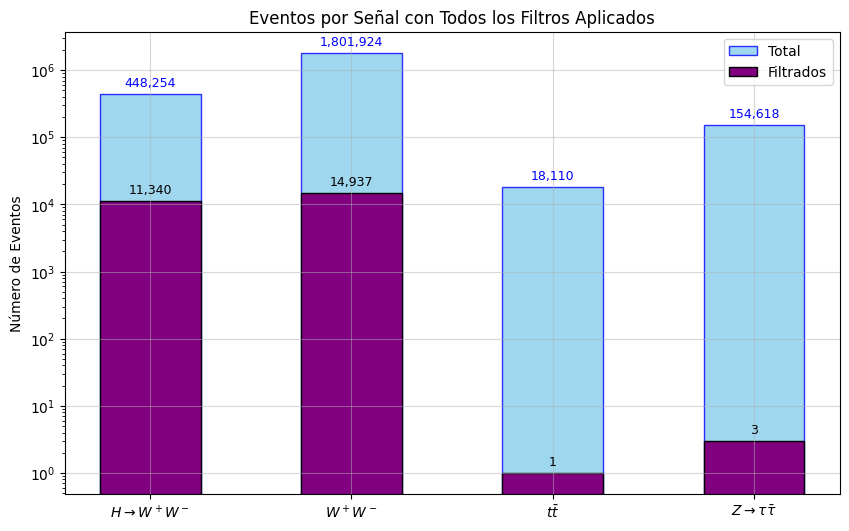

In [77]:
#import matplotlib.pyplot as plt

labels = [r'$H \rightarrow W^+W^-$', r'$W^+W^-$', r'$t \bar t$', r'$Z \rightarrow \tau \bar \tau$']
total_events = [448254, 1801924, 18110, 154618]
filtered_events = [11340, 14937, 1, 3]

plt.figure(figsize=(10, 6), dpi=100) 

# Barras totales
bars1 = plt.bar(labels, total_events, color='skyblue', width=0.5,
                edgecolor='blue', alpha=0.8, label='Total')

# Barras filtradas
bars2 = plt.bar(labels, filtered_events, color='purple', width=0.5,
                edgecolor='black', alpha=1, label='Filtrados')

plt.ylabel('Número de Eventos')
plt.yscale('log')
plt.title('Eventos por Señal con Todos los Filtros Aplicados')
plt.grid(alpha=0.5)
plt.legend()

# Etiquetas numéricas
for bars, color in zip([bars1, bars2], ['blue', 'black']):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.15,
                 f'{int(height):,}', ha='center', va='bottom',
                 fontsize=9, color=color)

# Guardar automáticamente
#plt.savefig('eventos_filtros.png', dpi=100, bbox_inches='tight')
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/eventos_filtros.png", dpi=100, bbox_inches='tight')


plt.show()

## Unión de Datos

In [78]:
## Funciones Auxiliares

def load_csv(path: str) -> pd.DataFrame:
    """
    Carga un archivo CSV con eventos preprocesados y verifica
    la presencia de las columnas físicas esperadas.

    Esta función se utiliza en la etapa de preparación de datos
    previa al entrenamiento de modelos de Machine Learning.

    Parameters
    ----------
    path : str
        Ruta al archivo CSV.

    Returns
    -------
    pandas.DataFrame
        DataFrame con los eventos cargados.

    Raises
    ------
    FileNotFoundError
        Si el archivo no existe.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe el archivo: {path}")

    df = pd.read_csv(path)

    expected_cols = [
        # Triggers
        "trigE", "trigM",

        # Conteos
        "lep_n", "jet_n",

        # MET
        "met_et", "met_phi",

        # Leptones
        "lep_pt_0", "lep_pt_1",
        "lep_eta_0", "lep_eta_1",
        "lep_E_0", "lep_E_1",
        "lep_phi_0", "lep_phi_1",
        "lep_charge_0", "lep_charge_1",
        "lep_type_0", "lep_type_1",
        "lep_ptcone30_0", "lep_ptcone30_1",

        # Jets
        "jet_pt", "jet_eta", "jet_phi", "jet_E", "jet_MV2c10",

        # Etiquetas y variables derivadas
        "sample",
        "mLL", "pTll", "dphi_ll", "dphi_ll_met"
    ]

    missing = [c for c in expected_cols if c not in df.columns]

    if missing:
        print(f"⚠️ Advertencia: faltan {len(missing)} columnas esperadas:")
        print(missing)
    else:
        print("✔ Todas las columnas físicas esperadas están presentes.")

    return df


###########



def assign_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    Asigna una etiqueta binaria de clasificación a partir de la columna 'sample'.

    Convención utilizada:
        - Higgs → 1 (señal)
        - Otros procesos (WW, ttbar, Z→ττ, etc.) → 0 (fondo)

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame que contiene la columna 'sample'.

    Returns
    -------
    pandas.DataFrame
        DataFrame con una nueva columna 'target'.

    Raises
    ------
    ValueError
        Si la columna 'sample' no existe.
    """
    if "sample" not in df.columns:
        raise ValueError("La columna 'sample' no existe en el dataset.")

    df = df.copy()

    df["target"] = df["sample"].apply(
        lambda s: 1 if s == "Higgs" else 0
    )

    return df

In [79]:
#import os
#import pandas as pd
#from sklearn.utils import shuffle
#from .load import load_csv, assign_target

'''
def merge_and_save(
    higgs_path: str,
    diboson_path: str,
    output_filename: str = "DatosUnidos.csv"
):
    """
    Une los datasets Higgs y DibosonWW.
    Crea la columna target correctamente.    0 -> Dibosón    1-> Higgs
    Mezcla los datos y los guarda en un CSV dentro de la carpeta DatosUnidos.
    ---
    Salidas: 
    df: pandas dataframe
    """

    print("Cargando datos filtrados reales...")
    higgs_df = load_csv(higgs_path)
    dib_df = load_csv(diboson_path)

    print(f"Higgs: {len(higgs_df)} eventos")
    print(f"DibosonWW: {len(dib_df)} eventos")

    # Asignar target ANTES de concatenar
    higgs_df["target"] = 1
    dib_df["target"] = 0

    # Unión
    df = pd.concat([higgs_df, dib_df], ignore_index=True)

    # Mezclar
    df = shuffle(df, random_state=42).reset_index(drop=True)

    # ==========================
    #   CARPETA DE SALIDA
    # ==========================
    output_dir = "DatosUnidos"
    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, output_filename)

    # ==========================
    #   GUARDAR EN CSV
    # ==========================
    df.to_csv(output_path, index=False)

    print(f"Dataset combinado guardado en: {output_path}")

    return df
'''

'\ndef merge_and_save(\n    higgs_path: str,\n    diboson_path: str,\n    output_filename: str = "DatosUnidos.csv"\n):\n    """\n    Une los datasets Higgs y DibosonWW.\n    Crea la columna target correctamente.    0 -> Dibosón    1-> Higgs\n    Mezcla los datos y los guarda en un CSV dentro de la carpeta DatosUnidos.\n    ---\n    Salidas: \n    df: pandas dataframe\n    """\n\n    print("Cargando datos filtrados reales...")\n    higgs_df = load_csv(higgs_path)\n    dib_df = load_csv(diboson_path)\n\n    print(f"Higgs: {len(higgs_df)} eventos")\n    print(f"DibosonWW: {len(dib_df)} eventos")\n\n    # Asignar target ANTES de concatenar\n    higgs_df["target"] = 1\n    dib_df["target"] = 0\n\n    # Unión\n    df = pd.concat([higgs_df, dib_df], ignore_index=True)\n\n    # Mezclar\n    df = shuffle(df, random_state=42).reset_index(drop=True)\n\n    # ==========================\n    #   CARPETA DE SALIDA\n    # ==========================\n    output_dir = "DatosUnidos"\n    os.makedirs(out

In [80]:
def merge_and_save(
    higgs_path: str,
    diboson_path: str,
    output_filename: str = "DatosUnidos.csv"
) -> pd.DataFrame:
    
    """
    Combina datasets de señal (Higgs) y fondo (Diboson WW),
    asigna la etiqueta binaria de clasificación y guarda el
    conjunto final en formato CSV.

    Esta función corresponde a la etapa de preparación de datos
    previa al entrenamiento de modelos de Machine Learning.

    Convención de etiquetas:
        - Higgs → target = 1 (señal)
        - Diboson WW → target = 0 (fondo)

    Parameters
    ----------
    higgs_path : str
        Ruta al CSV de la muestra Higgs filtrada.
    diboson_path : str
        Ruta al CSV de la muestra Diboson WW filtrada.
    output_filename : str, optional
        Nombre del archivo CSV de salida (default: "DatosUnidos.csv").

    Returns
    -------
    pandas.DataFrame
        DataFrame combinado, etiquetado y mezclado.
    """

    print("Cargando datasets filtrados...")
    higgs_df = load_csv(higgs_path)
    dib_df = load_csv(diboson_path)

    print(f"Higgs: {len(higgs_df)} eventos")
    print(f"Diboson WW: {len(dib_df)} eventos")

    # Asignación explícita del target antes de la unión
    higgs_df = higgs_df.copy()
    dib_df = dib_df.copy()

    higgs_df["target"] = 1
    dib_df["target"] = 0

    # Unión de señal y fondo
    df = pd.concat([higgs_df, dib_df], ignore_index=True)

    # Mezcla aleatoria para evitar ordenamiento por clase
    df = shuffle(df, random_state=42).reset_index(drop=True)

    # ==========================
    #   CARPETA DE SALIDA
    # ==========================
    output_dir = Path("DatosUnidos")
    output_dir.mkdir(parents=True, exist_ok=True)

    output_path = output_dir / output_filename

    # ==========================
    #   GUARDAR EN CSV
    # ==========================
    df.to_csv(output_path, index=False)

    print(f"Dataset combinado guardado en: {output_path.resolve()}")

    return df

In [81]:
'''
merged_df = merge_and_save(
    "DatosPreprocesadosCSV/datos_filtrados_Higgs.csv",
    "DatosPreprocesadosCSV/datos_filtrados_DibosonWW.csv"
)

df = merged_df.copy()
'''

'\nmerged_df = merge_and_save(\n    "DatosPreprocesadosCSV/datos_filtrados_Higgs.csv",\n    "DatosPreprocesadosCSV/datos_filtrados_DibosonWW.csv"\n)\n\ndf = merged_df.copy()\n'

In [82]:
# ============================================================
# Unión de muestras y construcción del dataset final para ML
# ============================================================

# Combina señal (Higgs) y fondo (Diboson WW), asigna etiquetas
# y genera el CSV del conjunto de entrenamiento
merged_df = merge_and_save(
    "DatosPreprocesadosCSV/datos_filtrados_Higgs.csv",
    "DatosPreprocesadosCSV/datos_filtrados_DibosonWW.csv"
)

# Copia de trabajo para análisis y modelado posterior
#df = merged_df.copy()

Cargando datasets filtrados...
✔ Todas las columnas físicas esperadas están presentes.
✔ Todas las columnas físicas esperadas están presentes.
Higgs: 11340 eventos
Diboson WW: 14937 eventos
Dataset combinado guardado en: /home/jovyan/SS/FullProject/DatosUnidos/DatosUnidos.csv


In [17]:
## Definción de Variable Requerida para Procesos Posteriores
df = pd.read_csv('DatosUnidos/DatosUnidos.csv')

In [84]:
df.head()

trigE  trigM  lep_n  jet_n     met_et   met_phi       lep_pt_0  \
0   True   True      2      0  39938.445  1.856930   39422.570312   
1   True   True      2      1  44835.996 -2.870015   55275.070312   
2   True  False      2      1  85033.480  0.415477   51790.308594   
3  False   True      2      1  80707.490 -2.295006  110044.054688   
4  False   True      2      0  63765.820  0.468712   45380.273438   

       lep_pt_1  lep_eta_0  lep_eta_1  ...   jet_eta   jet_phi         jet_E  \
0  26516.251953   0.571867  -0.233551  ...  0.000000  0.000000      0.000000   
1  29202.830078   0.167149   0.127004  ...  0.525750  2.928067  72089.546875   
2  20564.869141  -0.560513  -0.214823  ... -0.278951 -1.938559  21311.076172   
3  22830.406250  -0.192936  -0.658850  ...  0.277890 -0.491223  93733.585938   
4  22644.166016  -0.425893  -0.911751  ...  0.000000  0.000000      0.000000   

   jet_MV2c10  sample        mLL        pTll   dphi_ll  dphi_ll_met  target  
0    0.000000      WW  46.733593   53.660680  1.268602     3.098009       0  
1   -0.842718      WW  26.723835   80.155811  0.676783     2.675013       0  
2   -0.690779   Higgs  12.353210   72.188777  0.150418     2.628970       1  
3   -0.917005      WW  39.831298  128.935636  0.652169     1.997946       0  
4    0.000000   Higgs  24.319262   65.446771  0.587015     3.116981       1  

[5 rows x 35 columns]

# 3. Annálisis Exploratorio de Datos [Histogramas]

In [4]:
df_H = pd.read_csv('DatosUnidos/DatosUnidos.csv')

In [4]:
df_H.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26277 entries, 0 to 26276
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trigE            26277 non-null  bool   
 1   trigM            26277 non-null  bool   
 2   lep_n            26277 non-null  int64  
 3   jet_n            26277 non-null  int64  
 4   met_et           26277 non-null  float64
 5   met_phi          26277 non-null  float64
 6   lep_pt_0         26277 non-null  float64
 7   lep_pt_1         26277 non-null  float64
 8   lep_eta_0        26277 non-null  float64
 9   lep_eta_1        26277 non-null  float64
 10  lep_E_0          26277 non-null  float64
 11  lep_E_1          26277 non-null  float64
 12  lep_phi_0        26277 non-null  float64
 13  lep_phi_1        26277 non-null  float64
 14  lep_charge_0     26277 non-null  int64  
 15  lep_charge_1     26277 non-null  int64  
 16  lep_type_0       26277 non-null  int64  
 17  lep_type_1  

In [28]:
features_for_histograms = [
    # ==============================
    # PRIORIDAD ALTA (imprescindibles)
    # ==============================
    "met_et",
    "mLL",
    "pTll",
    "dphi_ll",
    "dphi_ll_met",

    # Leptones – cinemática
    "lep_pt_0",
    "lep_pt_1",
    "lep_eta_0",
    "lep_eta_1",
    "lep_E_0",
    "lep_E_1",
    "lep_phi_0",
    "lep_phi_1",

    # ==============================
    # PRIORIDAD MEDIA
    # ==============================
    # Aislamiento de leptones
    "lep_ptcone30_0",
    "lep_ptcone30_1",
    "lep_etcone20_0",
    "lep_etcone20_1",

    # Jets
    "jet_pt",
    "jet_eta",
    "jet_E",
    "jet_MV2c10",
]

latex_units = {
    # ==============================
    # PRIORIDAD ALTA
    # ==============================
    "met_et": r"$E_T^{miss}$ [GeV]",
    "mLL": r"$m_{\ell\ell}$ [GeV]",
    "pTll": r"$p_T^{\ell\ell}$ [GeV]",
    "dphi_ll": r"$\Delta\phi(\ell,\ell)$ [rad]",
    "dphi_ll_met": r"$\Delta\phi(\ell\ell, E_T^{miss})$ [rad]",

    # ==============================
    # Leptones – cinemática
    # ==============================
    "lep_pt_0": r"$p_T^{\ell_1}$ [GeV]",
    "lep_pt_1": r"$p_T^{\ell_2}$ [GeV]",
    "lep_eta_0": r"$\eta^{\ell_1}$",
    "lep_eta_1": r"$\eta^{\ell_2}$",
    "lep_E_0": r"$E^{\ell_1}$ [GeV]",
    "lep_E_1": r"$E^{\ell_2}$ [GeV]",
    "lep_phi_0": r"$\phi^{\ell_1}$ [rad]",
    "lep_phi_1": r"$\phi^{\ell_2}$ [rad]",

    # ==============================
    # PRIORIDAD MEDIA
    # ==============================
    # Aislamiento de leptones
    "lep_ptcone30_0": r"$p_T^{cone30}(\ell_1)$ [GeV]",
    "lep_ptcone30_1": r"$p_T^{cone30}(\ell_2)$ [GeV]",
    "lep_etcone20_0": r"$E_T^{cone20}(\ell_1)$ [GeV]",
    "lep_etcone20_1": r"$E_T^{cone20}(\ell_2)$ [GeV]",

    # ==============================
    # Jets
    # ==============================
    "jet_pt": r"$p_T^{jet}$ [GeV]",
    "jet_eta": r"$\eta^{jet}$",
    "jet_E": r"$E^{jet}$ [GeV]",
    "jet_MV2c10": r"$\mathrm{MV2c10}$ score",
}


In [13]:
def plot_normalized_histogram(
    df,
    var,
    target_col="target",
    signal_label=1,
    background_label=0,
    bins=40,
    output_dir="figures",
    figsize=(10, 6),
    dpi=100,
    x_label=None
):
    """
    Grafica y guarda un histograma normalizado que compara señal vs fondo
    para una variable dada.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada con los datos.
    var : str
        Nombre de la variable a graficar.
    target_col : str, opcional
        Nombre de la columna objetivo (default: "target").
    signal_label : int, opcional
        Etiqueta que identifica los eventos de señal (default: 1).
    background_label : int, opcional
        Etiqueta que identifica los eventos de fondo (default: 0).
    bins : int, opcional
        Número de bins del histograma (default: 40).
    output_dir : str, opcional
        Directorio donde se guardarán las figuras.
    figsize : tuple, opcional
        Tamaño de la figura.
    dpi : int, opcional
        Resolución de la figura.
    x_label : str, opcional
        Etiqueta del eje x. Útil para incluir unidades físicas
        (por ejemplo: "E_T^{miss} [GeV]").  
        Si es None, se usa el nombre de la variable.
    """

    # Separar clases
    df_sig = df[df[target_col] == signal_label][var]
    df_bkg = df[df[target_col] == background_label][var]

    # Bins comunes
    bin_edges = np.linspace(
        df[var].min(),
        df[var].max(),
        bins
    )

    plt.figure(figsize=figsize, dpi=dpi)

    # Background
    plt.hist(
        df_bkg,
        bins=bin_edges,
        density=True,
        histtype="stepfilled",
        edgecolor="#b35806",
        facecolor="#fdae61",
        alpha=0.5,
        linewidth=2,
        label="Fondo (Dibosón)"
    )

    # Signal
    plt.hist(
        df_sig,
        bins=bin_edges,
        density=True,
        histtype="stepfilled",
        edgecolor="blue",
        facecolor="skyblue",
        alpha=0.4,
        linewidth=2,
        label="Señal (Higgs)"
    )

    # Etiquetas
    plt.xlabel(x_label if x_label is not None else var)
    plt.ylabel("Número de eventos (normalizados)")
    plt.title(f"Histograma normalizado de {var}")
    plt.grid(alpha=0.5)
    plt.legend()
    plt.tight_layout()

    # Guardado automático
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(
        f"{output_dir}/hist_{var}.png",
        dpi=dpi,
        bbox_inches="tight"
    )

    plt.show()


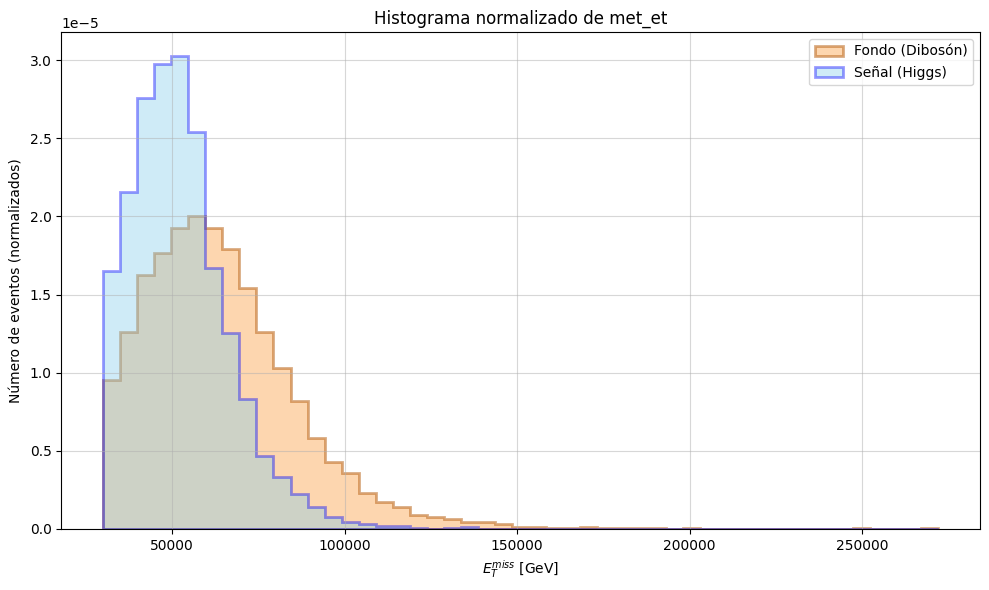

In [16]:
plot_normalized_histogram(
    df_H,
    var="met_et",
    bins=50,
    x_label=r"$E_T^{miss}$ [GeV]"
)

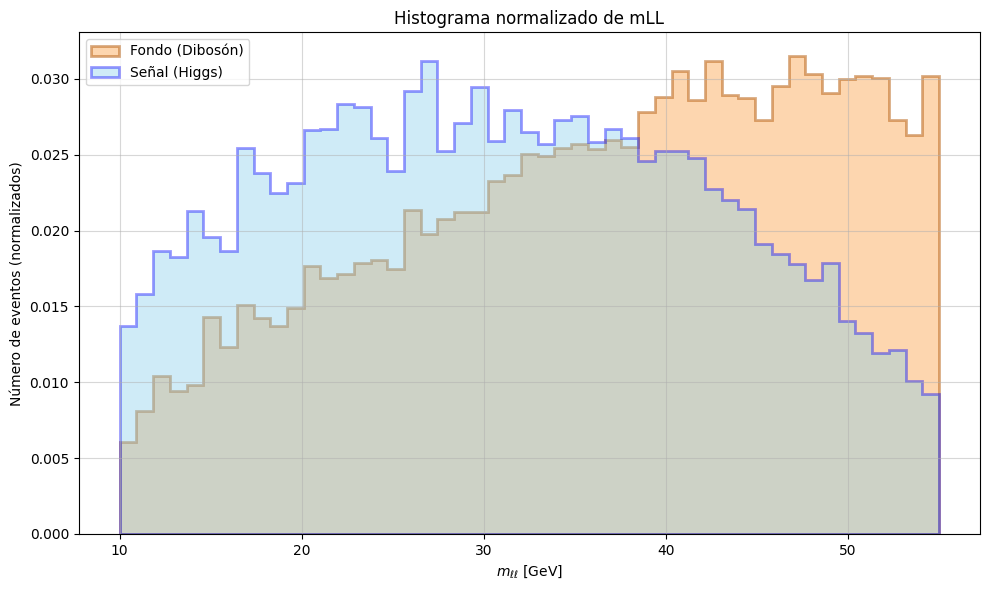

In [23]:
plot_normalized_histogram(
    df_H,
    var="mLL",
    bins=50,
    x_label=r"$m_{\ell\ell}$ [GeV]"
)

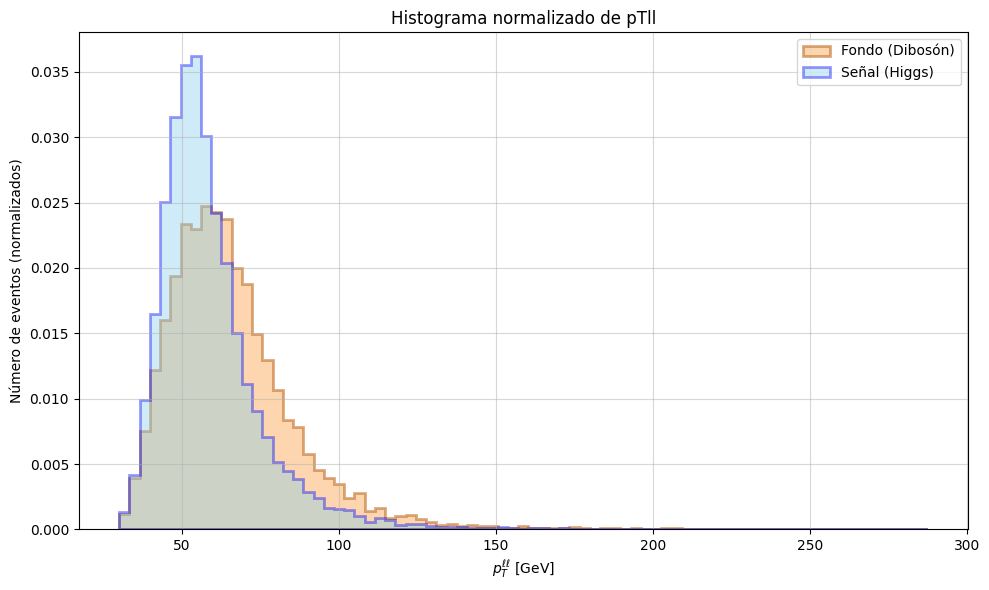

In [25]:
plot_normalized_histogram(
    df_H,
    var="pTll",
    bins=80,
    x_label=r"$p_T^{\ell\ell}$ [GeV]"
)

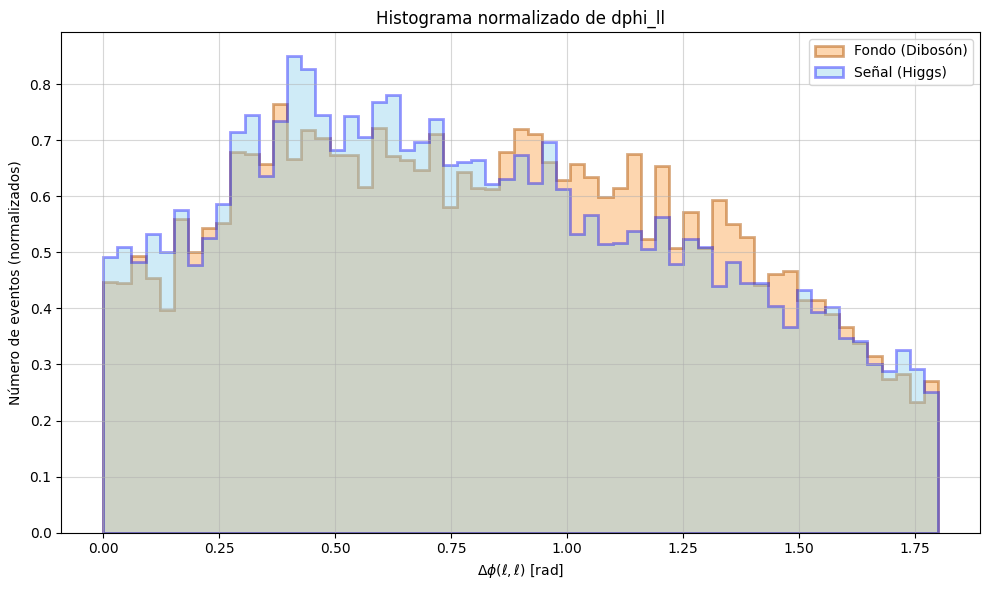

In [39]:
plot_normalized_histogram(
    df_H,
    var="dphi_ll",
    bins=60,
    x_label=r"$\Delta\phi(\ell,\ell)$ [rad]"
)

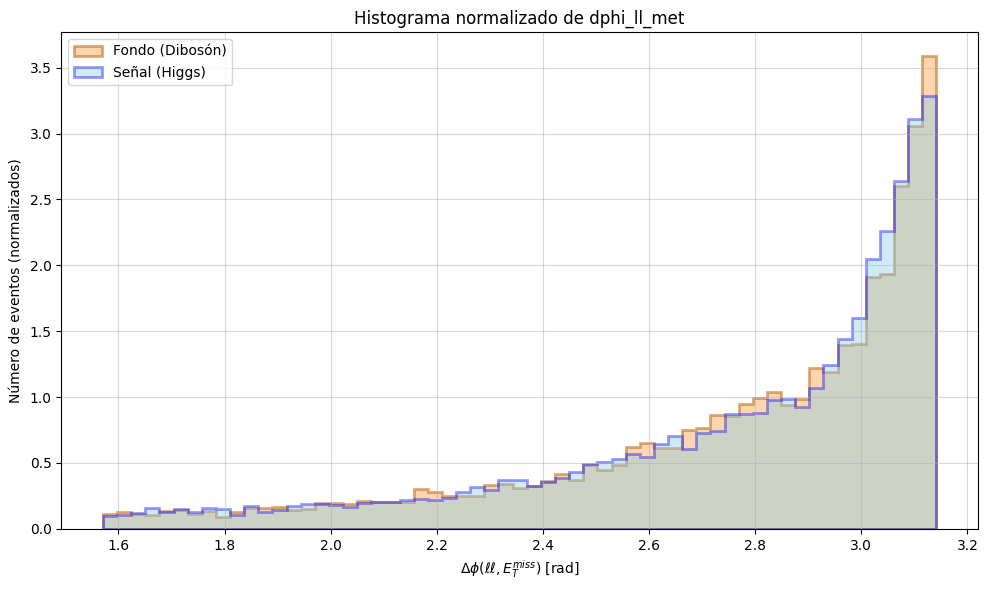

In [44]:
plot_normalized_histogram(
    df_H,
    var="dphi_ll_met",
    bins=60,
    x_label=r"$\Delta\phi(\ell\ell, E_T^{miss})$ [rad]"
)

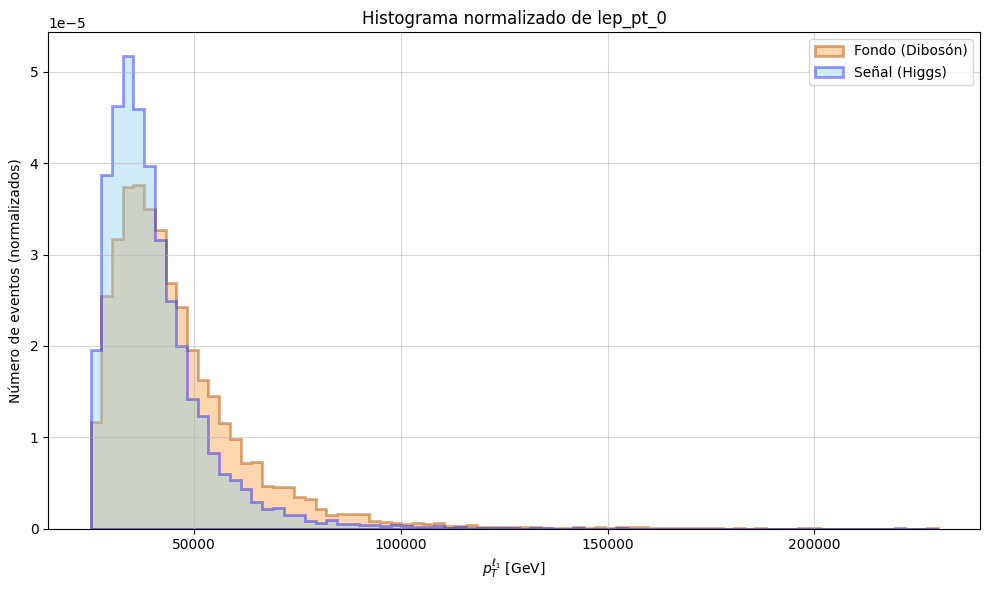

In [46]:
plot_normalized_histogram(
    df_H,
    var="lep_pt_0",
    bins=80,
    x_label=r"$p_T^{\ell_1}$ [GeV]"
)

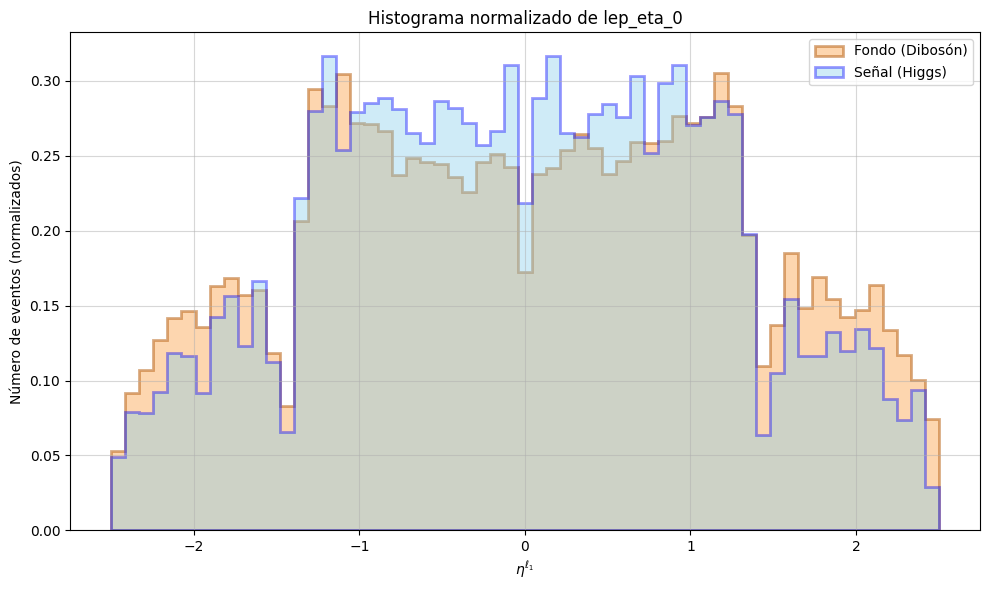

In [54]:
plot_normalized_histogram(
    df_H,
    var="lep_eta_0",
    bins=60,
    x_label=r"$\eta^{\ell_1}$"
)

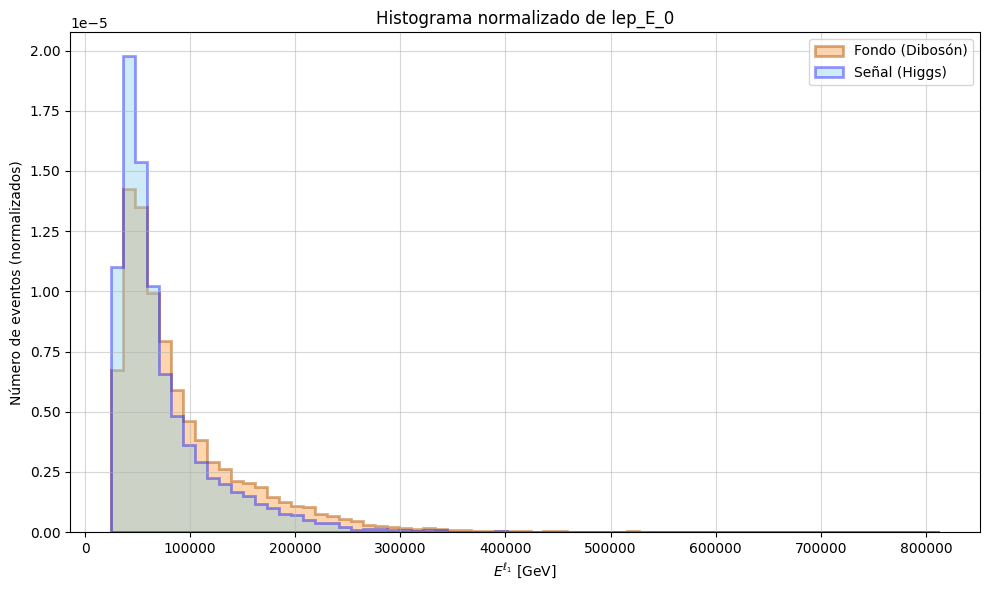

In [56]:
plot_normalized_histogram(
    df_H,
    var="lep_E_0",
    bins=70,
    x_label=r"$E^{\ell_1}$ [GeV]"
)

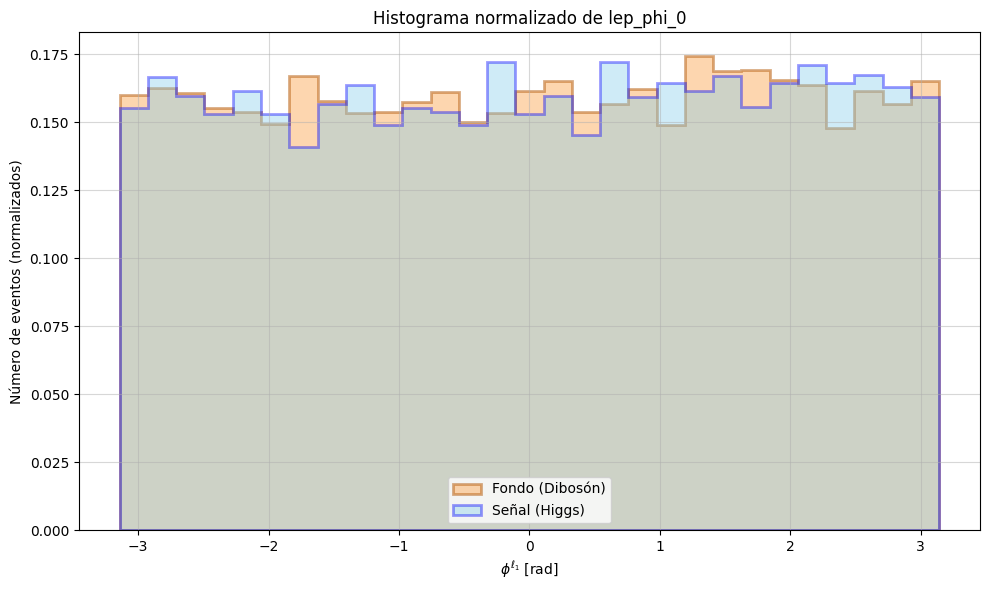

In [61]:
plot_normalized_histogram(
    df_H,
    var="lep_phi_0",
    bins=30,
    x_label=r"$\phi^{\ell_1}$ [rad]"
)

In [ ]:
    "jet_pt": r"$p_T^{jet}$ [GeV]",
    "jet_eta": r"$\eta^{jet}$",
    "jet_E": r"$E^{jet}$ [GeV]",
    "jet_MV2c10": r"$\mathrm{MV2c10}$ score",

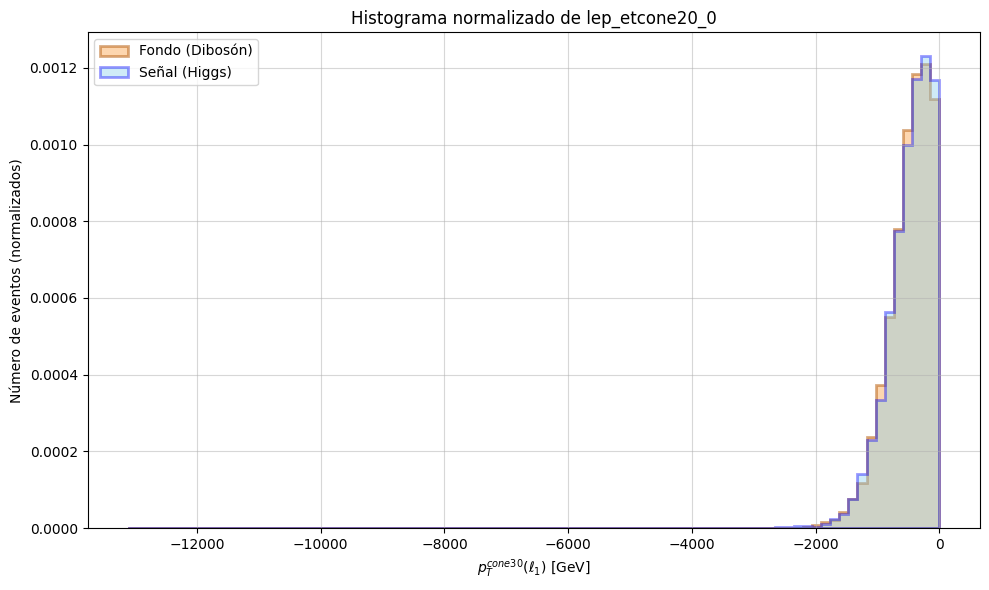

In [82]:
plot_normalized_histogram(
    df_H,
    var="lep_etcone20_0",
    bins=90,
    x_label=r"$p_T^{cone30}(\ell_1)$ [GeV]"
)

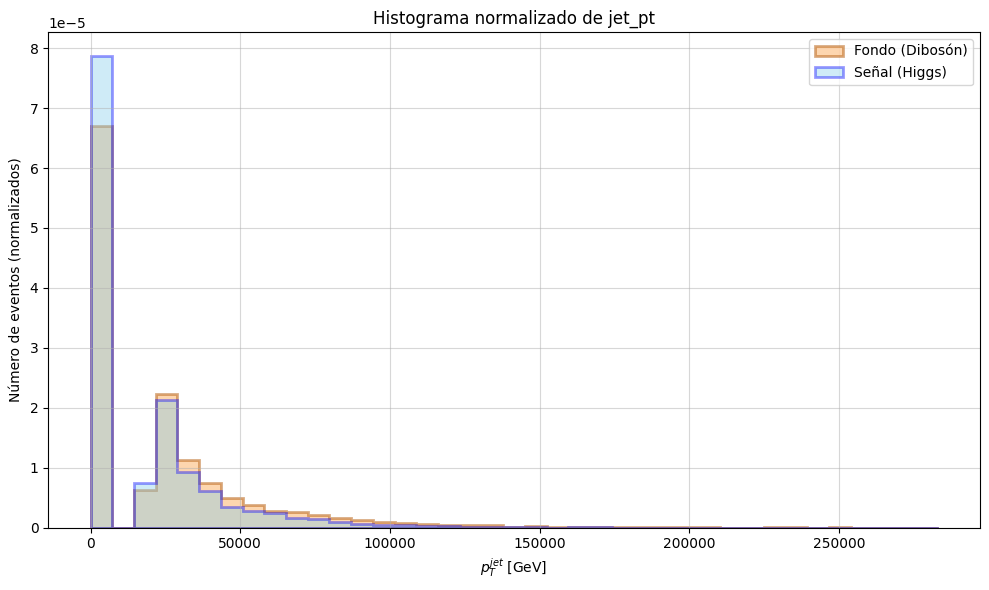

In [88]:
plot_normalized_histogram(
    df_H,
    var="jet_eta",
    bins=40,
    x_label=r"$p_T^{jet}$ [GeV]"
)

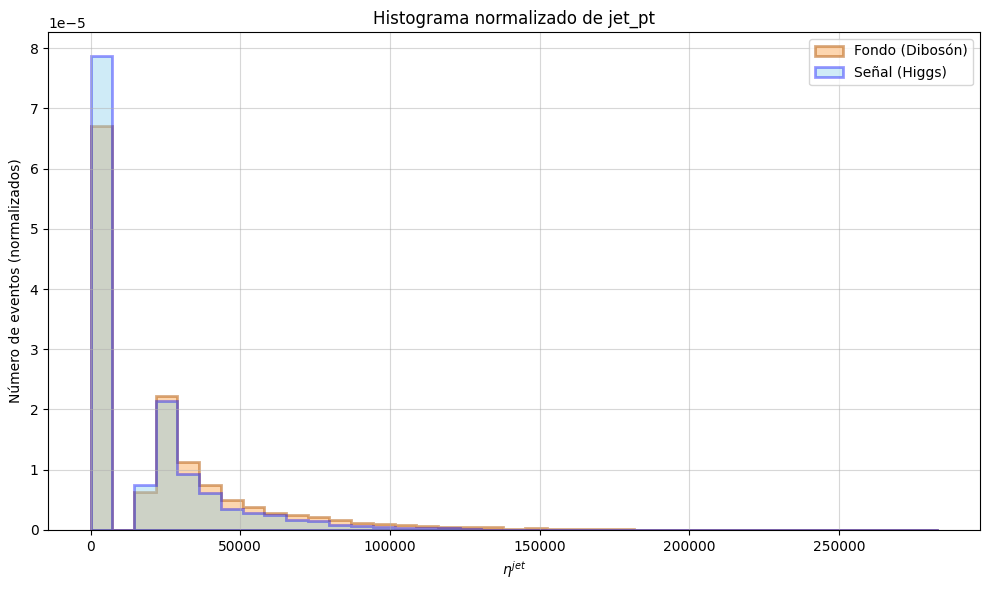

In [89]:
plot_normalized_histogram(
    df_H,
    var="jet_pt",
    bins=40,
    x_label=r"$\eta^{jet}$"
)

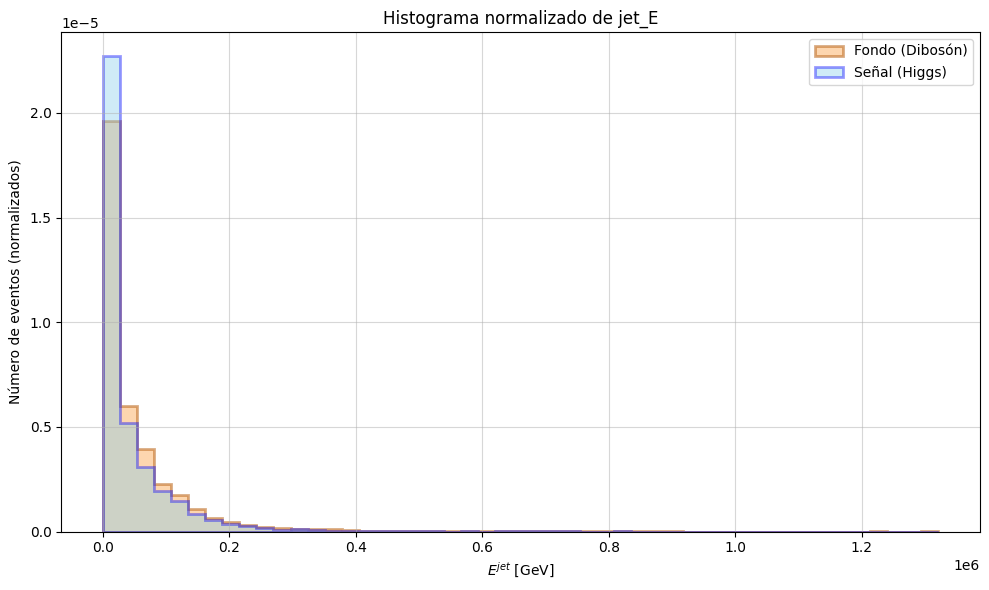

In [92]:
plot_normalized_histogram(
    df_H,
    var="jet_E",
    bins=50,
    x_label=r"$E^{jet}$ [GeV]"
)

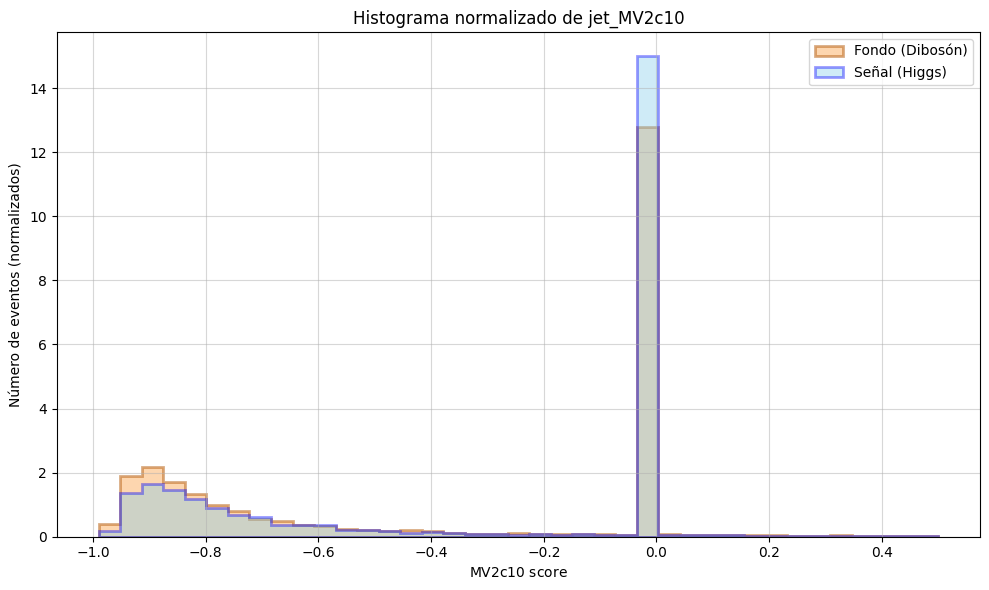

In [98]:
plot_normalized_histogram(
    df_H,
    var="jet_MV2c10",
    bins=40,
    x_label=r"$\mathrm{MV2c10}$ score"
)

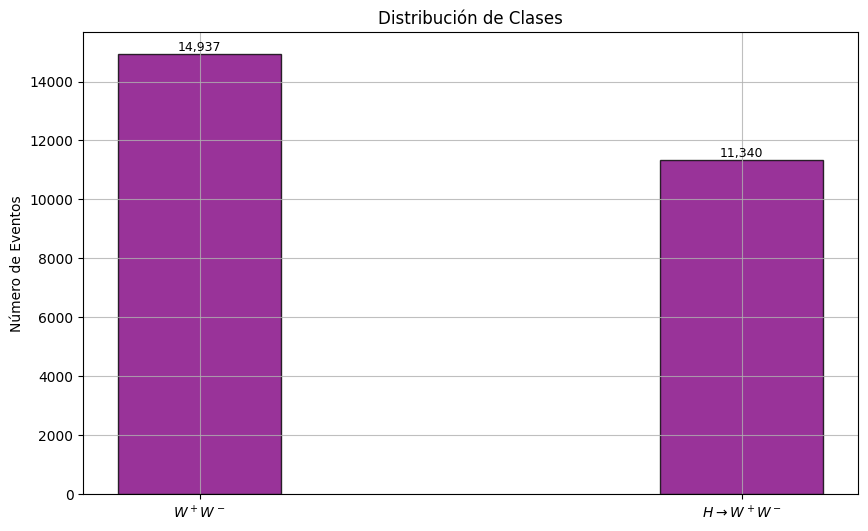

In [85]:
## Desbalance de Calses
class_counts = df["target"].value_counts().sort_index()

labels = [r'$W^+W^-$', r'$H \rightarrow W^+W^-$']
counts = class_counts.values

# ==========================
#   FIGURA
# ==========================
plt.figure(figsize=(10, 6), dpi=100)

bars = plt.bar(
    labels,
    counts,
    color="purple",
    width=0.3,
    edgecolor="black",
    alpha=0.8
)

plt.ylabel("Número de Eventos")
#plt.yscale("log")
plt.title("Distribución de Clases")
#plt.label()
plt.grid(alpha=0.8)

# ==========================
#   ETIQUETAS NUMÉRICAS
# ==========================
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height * 1,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="black"
    )

# ==========================
#   GUARDAR FIGURA
# ==========================
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/balance_clases.png", dpi=100, bbox_inches="tight")

plt.show()


In [86]:
class_counts

target
0    14937
1    11340
Name: count, dtype: int64

In [87]:
porcentajes = class_counts / class_counts.sum() * 100
porcentajes

target
0    56.844389
1    43.155611
Name: count, dtype: float64

In [88]:
labels = {
    0: "Dibosón (fondo)",
    1: "Higgs (señal)"
}

resumen = pd.DataFrame({
    "Eventos": class_counts,
    "Porcentaje (%)": porcentajes.round(2)
})

resumen["Clase física"] = resumen.index.map(labels)

resumen

Eventos  Porcentaje (%)     Clase física
target                                          
0         14937           56.84  Dibosón (fondo)
1         11340           43.16    Higgs (señal)

Los eventos de fondo asociados a procesos dibosónicos representan el 56.84 % de los datos y eventos de señal correspondientes a la producción del bosón de Higgs el 43.16 %.

Esta distribución refleja un desbalance moderado entre clases, el cual no es extremo pero sí suficientemente relevante como para requerir técnicas de validación estratificada, como StratifiedKFold, con el fin de preservar la proporción señal–fondo en los conjuntos de entrenamiento y prueba.

La ausencia de valores faltantes y la correcta definición de variables físicas indican una alta calidad de los datos, permitiendo un análisis confiable tanto en la exploración de distribuciones como en la etapa de modelado supervisado.

# 4. Análisis Preliminar de de Importancia de Variables

In [94]:
#from sklearn.ensemble import RandomForestClassifier

In [18]:
# Separación de variables predictoras y etiqueta
## Definición de Variables Requerida en Procesos Posteriores
X = df.drop(columns=["target", "sample"])
y = df["target"]

In [96]:
# Entrenamiento de un modelo Random Forest para estimar importancia de variables
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X, y)

# Importancia de variables basada en reducción de impureza
importances = pd.Series(rf.feature_importances_, index=X.columns)

# Visualización de importancias (orden ascendente)
#importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 12))
#plt.title("Importancia preliminar de variables (Random Forest)")
#plt.grid()
#plt.show()

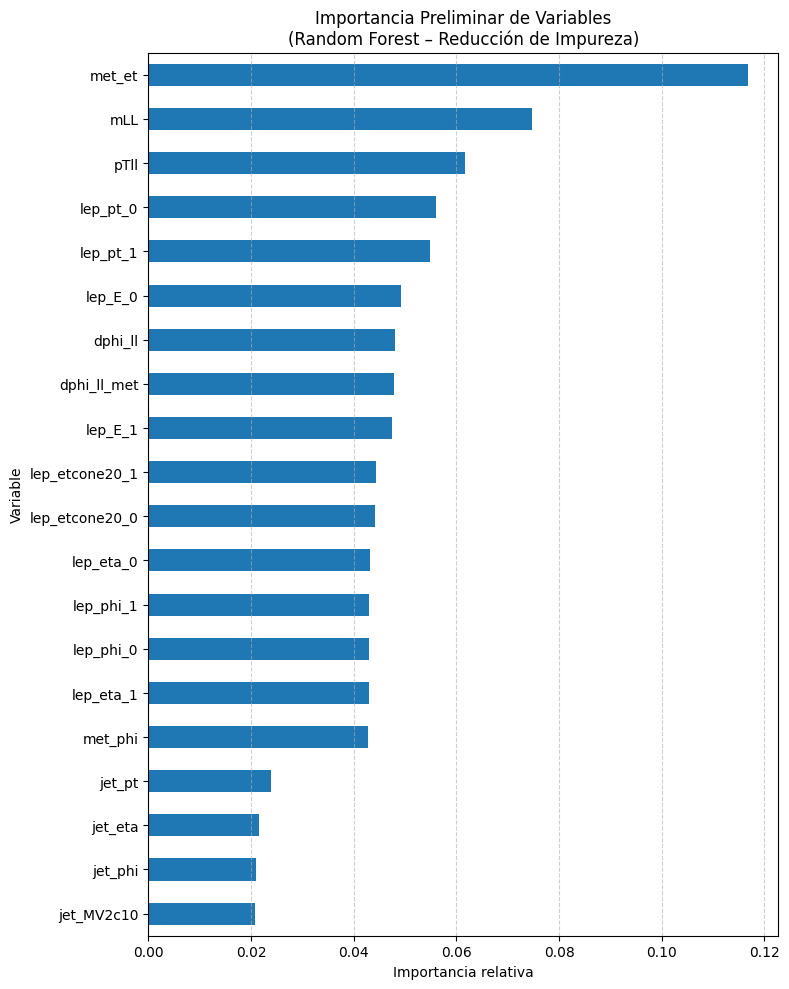

In [97]:
# Número de variables más relevantes a mostrar
top_n = 20

# Selección de las variables más importantes
importances_top = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(8, 10))
importances_top.sort_values().plot(kind="barh")

plt.title(
    "Importancia Preliminar de Variables\n(Random Forest – Reducción de Impureza)",
    fontsize=12
)
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


El análisis de importancia de variables indica que la energía faltante transversal es el observable con mayor poder discriminante entre señal y fondo, seguida por la masa invariante dileptónica, la cual actúa como una variable sintética altamente eficiente. Estas variables, junto con el momento del sistema dileptonico , capturan aspectos clave de la cinemática y topología del proceso de decaimiento del bosón de Higgs.

El dataset presenta un desbalance moderado (43 % señal y 57 % fondo), lo que motiva el uso de validación estratificada para preservar la proporción de clases durante el entrenamiento. Asimismo, la ausencia de valores faltantes y la correcta definición de las variables físicas reflejan una alta calidad de los datos, resultado de un preprocesamiento adecuado.

La elección de modelos de boosting basados en árboles de decisión (XGBoost/LightGBM) está justificada por su capacidad para modelar relaciones no lineales, su robustez ante outliers y variables heterogéneas, su manejo eficiente de eventos con información escasa y su desempeño óptimo en datasets tabulares de tamaño medio, evitando el sobreajuste asociado a modelos de deep learning en este régimen de datos.

# 5. Modelado Base (Baseline)

In [98]:
#from sklearn.model_selection import StratifiedKFold, cross_validate
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.svm import SVC
#from sklearn.linear_model import LogisticRegression

#from lightgbm import LGBMClassifier
#from xgboost import XGBClassifier

In [99]:
#!pip install lightgbm

In [100]:
#!pip install xgboost

In [101]:
models = {
    # 🌳 Bagging
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),

    # 🌲 Boosting clásico (sklearn)
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    ),

    # 🚀 LightGBM (GBDT optimizado)
    "LightGBM": LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),

    # ⚡ XGBoost
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),

    # ⚙️ SVM
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", probability=True, random_state=42))
    ]),

    # 📐 Baseline lineal
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, random_state=42))
    ])
}

In [102]:
# Esquema de Validación Cruzada Estratificada (preserva proporción señal/fondo)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [103]:
# Métricas de evaluación para validación cruzada
scoring = {
    "accuracy": "accuracy",
    "auc": "roc_auc",
    "f1": "f1"
}

In [104]:
# Evaluación de Modelos con Validación Cruzada
results = []

for name, model in models.items():

    print(f"Evaluando {name}...")

    # Validación Cruzada
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    # Resumen Estadístico
    results.append({
        "model": name,
        "accuracy_mean": cv_results["test_accuracy"].mean(),
        "accuracy_std":  cv_results["test_accuracy"].std(),
        "auc_mean":      cv_results["test_auc"].mean(),
        "auc_std":       cv_results["test_auc"].std(),
        "f1_mean":       cv_results["test_f1"].mean(),
        "f1_std":        cv_results["test_f1"].std()
    })

Evaluando RandomForest...
Evaluando GradientBoosting...
Evaluando LightGBM...
Evaluando XGBoost...
Evaluando SVM (RBF)...
[LightGBM] [Info] Number of positive: 9072, number of negative: 11950
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5373
[LightGBM] [Info] Number of data points in the train set: 21022, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431548 -> initscore=-0.275539
[LightGBM] [Info] Start training from score -0.275539
[LightGBM] [Info] Number of positive: 9072, number of negative: 11949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5373
[LightGBM] [Info] Number of data points in the train set: 21021, number of used features: 28
[LightGBM] [Info] [binary:

In [105]:
# ============================================================
# Resultados de modelos baseline (Validación Cruzada)
# ============================================================

# Conversión de resultados a DataFrame y orden por AUC media
results_df = (
    pd.DataFrame(results)
    .sort_values("auc_mean", ascending=False)
    .reset_index(drop=True)
)

# Redondeo para mejor legibilidad
results_df = results_df.round(4)

print(results_df)

                model  accuracy_mean  accuracy_std  auc_mean  auc_std  \
0    GradientBoosting         0.6789        0.0033    0.7472   0.0043   
1            LightGBM         0.6770        0.0044    0.7435   0.0048   
2        RandomForest         0.6762        0.0032    0.7428   0.0033   
3             XGBoost         0.6729        0.0061    0.7413   0.0040   
4           SVM (RBF)         0.6779        0.0043    0.7404   0.0042   
5  LogisticRegression         0.6658        0.0035    0.7322   0.0080   

   f1_mean  f1_std  
0   0.6334  0.0071  
1   0.6330  0.0065  
2   0.6173  0.0040  
3   0.6267  0.0073  
4   0.6361  0.0054  
5   0.5985  0.0063  


In [106]:
# ============================================================
# Resultados de modelos baseline (Validación Cruzada)
# Métricas reportadas como media ± desviación estándar
# ============================================================

results_df = (
    pd.DataFrame(results)
    .sort_values("auc_mean", ascending=False)
    .reset_index(drop=True)
)

# Construcción de columnas en formato media ± std
results_df["Accuracy"] = results_df.apply(
    lambda r: f"{r['accuracy_mean']:.3f} ± {r['accuracy_std']:.3f}", axis=1
)
results_df["AUC"] = results_df.apply(
    lambda r: f"{r['auc_mean']:.3f} ± {r['auc_std']:.3f}", axis=1
)
results_df["F1"] = results_df.apply(
    lambda r: f"{r['f1_mean']:.3f} ± {r['f1_std']:.3f}", axis=1
)

# Selección y orden final de columnas para presentación
results_presentacion = results_df[
    ["model", "Accuracy", "AUC", "F1"]
]

print(results_presentacion)


                model       Accuracy            AUC             F1
0    GradientBoosting  0.679 ± 0.003  0.747 ± 0.004  0.633 ± 0.007
1            LightGBM  0.677 ± 0.004  0.743 ± 0.005  0.633 ± 0.007
2        RandomForest  0.676 ± 0.003  0.743 ± 0.003  0.617 ± 0.004
3             XGBoost  0.673 ± 0.006  0.741 ± 0.004  0.627 ± 0.007
4           SVM (RBF)  0.678 ± 0.004  0.740 ± 0.004  0.636 ± 0.005
5  LogisticRegression  0.666 ± 0.004  0.732 ± 0.008  0.598 ± 0.006


# 6. Esquema para Validación Cruzada [Folds Estratificados (Archivos)] *

In [107]:
def generate_folds(
    merged_path: str = "DatosUnidos/DatosUnidos.csv",
    output_dir: str = "Folds",
    n_splits: int = 5,
    random_state: int = 42
) -> None:
    
    """
    Genera folds estratificados a partir del dataset unificado y
    guarda los conjuntos de entrenamiento y validación en archivos CSV.

    Esta función se utiliza para establecer un esquema de validación
    cruzada reproducible, preservando la proporción señal/fondo
    en cada fold.

    Parameters
    ----------
    merged_path : str
        Ruta al archivo CSV con el dataset combinado.
    output_dir : str
        Directorio donde se guardarán los folds generados.
    n_splits : int
        Número de folds para la validación cruzada.
    random_state : int
        Semilla aleatoria para reproducibilidad.

    Returns
    -------
    None
    """

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Cargar dataset unificado
    print(f"Cargando dataset desde: {merged_path}")
    df = pd.read_csv(merged_path)

    # Verificación mínima
    if "target" not in df.columns:
        raise ValueError("La columna 'target' no existe en el dataset.")

    # Variables predictoras y etiqueta
    X = df.drop(columns=["target"])
    y = df["target"]

    # Definición del esquema de validación cruzada estratificada
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    print(f"\nGenerando {n_splits} folds estratificados...\n")

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):

        # Conjuntos de entrenamiento y validación para el fold actual
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df   = df.iloc[val_idx].reset_index(drop=True)

        train_path = output_dir / f"fold_{fold_idx}_train.csv"
        val_path   = output_dir / f"fold_{fold_idx}_val.csv"

        train_df.to_csv(train_path, index=False)
        val_df.to_csv(val_path, index=False)

        print(f"Fold {fold_idx}:")
        print(f"  - Train: {train_df.shape[0]} eventos → {train_path}")
        print(f"  - Val:   {val_df.shape[0]} eventos → {val_path}\n")

    print("✔ Folds generados correctamente.\n")


In [108]:
'''
## Función Auxiliar

#from sklearn.model_selection import StratifiedKFold

def generate_folds(
    merged_path: str = "DatosUnidos/DatosUnidos.csv",
    output_dir: str = "Folds",
    n_splits: int = 5,
    random_state: int = 42
):
    """
    Genera folds estratificados.
    Lee datos desde CSV y guarda cada fold como CSV.
    """

    # Crear carpeta de salida si no existe
    os.makedirs(output_dir, exist_ok=True)

    # Cargar dataset unificado
    print(f"Cargando dataset desde: {merged_path}")
    df = pd.read_csv(merged_path)

    # Verificación mínima
    if "target" not in df.columns:
        raise ValueError("La columna 'target' no existe en el dataset")

    # Features y target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Stratified K-Fold
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    print(f"\nGenerando {n_splits} folds estratificados...\n")

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):

        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df   = df.iloc[val_idx].reset_index(drop=True)

        train_path = os.path.join(output_dir, f"fold_{fold_idx}_train.csv")
        val_path   = os.path.join(output_dir, f"fold_{fold_idx}_val.csv")

        train_df.to_csv(train_path, index=False)
        val_df.to_csv(val_path, index=False)

        print(f"Fold {fold_idx}:")
        print(f"  - Train: {train_df.shape[0]} filas → {train_path}")
        print(f"  - Val:   {val_df.shape[0]} filas → {val_path}\n")

    print("✔ Folds generados correctamente.\n")
'''

'\n## Función Auxiliar\n\n#from sklearn.model_selection import StratifiedKFold\n\ndef generate_folds(\n    merged_path: str = "DatosUnidos/DatosUnidos.csv",\n    output_dir: str = "Folds",\n    n_splits: int = 5,\n    random_state: int = 42\n):\n    """\n    Genera folds estratificados.\n    Lee datos desde CSV y guarda cada fold como CSV.\n    """\n\n    # Crear carpeta de salida si no existe\n    os.makedirs(output_dir, exist_ok=True)\n\n    # Cargar dataset unificado\n    print(f"Cargando dataset desde: {merged_path}")\n    df = pd.read_csv(merged_path)\n\n    # Verificación mínima\n    if "target" not in df.columns:\n        raise ValueError("La columna \'target\' no existe en el dataset")\n\n    # Features y target\n    X = df.drop(columns=["target"])\n    y = df["target"]\n\n    # Stratified K-Fold\n    skf = StratifiedKFold(\n        n_splits=n_splits,\n        shuffle=True,\n        random_state=random_state\n    )\n\n    print(f"\nGenerando {n_splits} folds estratificados...\n

In [109]:
# ============================================================
# Gestión de folds para validación cruzada
# Evita regenerar folds si ya existen en disco
# ============================================================

folds_dir = "Folds"
merged_path = "DatosUnidos/DatosUnidos.csv"

# Verificación de existencia previa de folds
if os.path.exists(folds_dir) and len(os.listdir(folds_dir)) > 0:
    print(f"Folds ya generados en: {folds_dir}")
    print(f"Total de archivos: {len(os.listdir(folds_dir))}")
else:
    print("Generando folds estratificados...")
    generate_folds(
        merged_path=merged_path,
        output_dir=folds_dir,
        n_splits=5,
        random_state=42
    )
    print(f"Folds guardados en: {folds_dir}")

Folds ya generados en: Folds
Total de archivos: 11


# 7. Selección de Características *

In [110]:
## Carga de Fold
def load_fold_csv(train_path, val_path):
    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    return train_df, val_df


In [111]:
## Selección de Características

def select_top_features_cv(
    folds_dir="Folds",
    top_k=16,
    n_folds=5
):
    """
    Selecciona features usando importancia promedio en CV.
    """

    feature_scores = {}

    for i in range(1, n_folds + 1):

        train_path = f"{folds_dir}/fold_{i}_train.csv"
        val_path   = f"{folds_dir}/fold_{i}_val.csv"

        train_df, val_df = load_fold_csv(train_path, val_path)

        X_train = train_df.drop(columns=["target", "sample"])
        y_train = train_df["target"]

        model = LGBMClassifier(
            n_estimators=300,
            learning_rate=0.05,
            random_state=42
        )

        model.fit(X_train, y_train)

        importances = model.feature_importances_

        for feat, imp in zip(X_train.columns, importances):
            feature_scores.setdefault(feat, []).append(imp)

    # Promedio de importancia entre folds
    feature_mean_importance = {
        feat: np.mean(imps) for feat, imps in feature_scores.items()
    }

    importance_df = (
        pd.DataFrame.from_dict(
            feature_mean_importance,
            orient="index",
            columns=["mean_importance"]
        )
        .sort_values("mean_importance", ascending=False)
    )

    selected_features = importance_df.head(top_k).index.tolist()

    return selected_features, importance_df


In [112]:
print("Seleccionando las 16 mejores variables con CV...")

top_features, ranking_df = select_top_features_cv(
    folds_dir="Folds",
    top_k=16
)

print("\nTop 16 variables seleccionadas:")
for f in top_features:
    print(f" - {f}")


Seleccionando las 16 mejores variables con CV...
[LightGBM] [Info] Number of positive: 9072, number of negative: 11949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5373
[LightGBM] [Info] Number of data points in the train set: 21021, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431568 -> initscore=-0.275455
[LightGBM] [Info] Start training from score -0.275455
[LightGBM] [Info] Number of positive: 9072, number of negative: 11949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5373
[LightGBM] [Info] Number of data points in the train set: 21021, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431568 -> initscore=-0.275455
[LightGBM] [Info] S

In [113]:
ranking_df.head(20)

mean_importance
met_et                    757.0
dphi_ll_met               611.8
mLL                       610.6
pTll                      505.4
lep_etcone20_0            500.6
lep_pt_1                  475.6
lep_pt_0                  466.8
lep_etcone20_1            464.2
lep_E_0                   420.6
dphi_ll                   412.4
lep_E_1                   405.4
met_phi                   402.8
jet_pt                    381.8
lep_phi_1                 375.6
lep_eta_0                 369.2
lep_phi_0                 364.0
lep_eta_1                 362.4
jet_eta                   280.8
jet_MV2c10                265.4
jet_phi                   247.4

# 8. Entrenamiento de Modelos con Conjunto de Características Reducidas

In [114]:
top_features

['met_et',
 'dphi_ll_met',
 'mLL',
 'pTll',
 'lep_etcone20_0',
 'lep_pt_1',
 'lep_pt_0',
 'lep_etcone20_1',
 'lep_E_0',
 'dphi_ll',
 'lep_E_1',
 'met_phi',
 'jet_pt',
 'lep_phi_1',
 'lep_eta_0',
 'lep_phi_0']

In [116]:
## Carga de Datos (Originales)
df = pd.read_csv("DatosUnidos/DatosUnidos.csv")

## Caracterísicas Seleccionadas
X = df[top_features]
y = df["target"]

In [117]:
# Evaluación de Modelos con Características Reducidas
results = []

for name, model in models.items():

    print(f"Entrenando {name} con top-16 features...")

    # Validación Cruzada Estratíficada con Múltiples Métricas
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    # Desempeño Promedio y Variabilidad entre Folds
    results.append({
        "model": name,
        "accuracy_mean": cv_results["test_accuracy"].mean(),
        "accuracy_std":  cv_results["test_accuracy"].std(),
        "auc_mean":      cv_results["test_auc"].mean(),
        "auc_std":       cv_results["test_auc"].std(),
        "f1_mean":       cv_results["test_f1"].mean(),
        "f1_std":        cv_results["test_f1"].std()
    })


Entrenando RandomForest con top-16 features...
Entrenando GradientBoosting con top-16 features...
Entrenando LightGBM con top-16 features...
Entrenando XGBoost con top-16 features...
Entrenando SVM (RBF) con top-16 features...
Entrenando LogisticRegression con top-16 features...


In [118]:
# ============================================================
# Resultados de modelos (Validación Cruzada con top-16 features)
# Métricas reportadas como media ± desviación estándar
# ============================================================

# Conversión de resultados a DataFrame y orden por AUC media
results_df = (
    pd.DataFrame(results)
    .sort_values("auc_mean", ascending=False)
    .reset_index(drop=True)
)

# Construcción de métricas en formato media ± std
results_df["Accuracy"] = results_df.apply(
    lambda r: f"{r['accuracy_mean']:.3f} ± {r['accuracy_std']:.3f}", axis=1
)
results_df["AUC"] = results_df.apply(
    lambda r: f"{r['auc_mean']:.3f} ± {r['auc_std']:.3f}", axis=1
)
results_df["F1"] = results_df.apply(
    lambda r: f"{r['f1_mean']:.3f} ± {r['f1_std']:.3f}", axis=1
)

# Selección y orden final de columnas para presentación
results_presentacion = results_df[
    ["model", "Accuracy", "AUC", "F1"]
]

# Visualización de la tabla de resultados
print(results_presentacion.to_string(index=False))


             model      Accuracy           AUC            F1
  GradientBoosting 0.679 ± 0.003 0.747 ± 0.004 0.634 ± 0.007
          LightGBM 0.678 ± 0.005 0.744 ± 0.004 0.636 ± 0.006
         SVM (RBF) 0.679 ± 0.007 0.742 ± 0.004 0.640 ± 0.007
           XGBoost 0.674 ± 0.004 0.741 ± 0.004 0.628 ± 0.007
      RandomForest 0.674 ± 0.003 0.741 ± 0.005 0.623 ± 0.004
LogisticRegression 0.666 ± 0.002 0.731 ± 0.008 0.598 ± 0.005


Los modelos basados en boosting y SVM presentan desempeños comparables dentro de la incertidumbre estadística. Aunque GradientBoosting alcanza el mayor AUC promedio, se seleccionó LightGBM como modelo final debido a su mayor flexibilidad, eficiencia computacional y potencial de mejora mediante ajuste de hiperparámetros, manteniendo un desempeño competitivo en todas las métricas evaluadas

# 9. Optimización de Hiperparámetros: Optimización Bayesiana

In [25]:
# ============================================================
# Función objetivo para optimización bayesiana (Optuna)
# Optimiza hiperparámetros de LightGBM usando AUC en CV
# ============================================================

def objective(trial):

    # Espacio de búsqueda de hiperparámetros
    params = {
        "n_estimators": 400,
        "learning_rate": 0.05,
        "num_leaves": trial.suggest_int("num_leaves", 15, 80),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.95),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.95),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "random_state": 42,
        "n_jobs": -1
    }

    # Modelo a Optimizar
    model = LGBMClassifier(**params)

    # Evaluación mediante validación cruzada estratificada
    scores = cross_val_score(
        model,
        X[top_features],
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

In [26]:
# Configuración del estudio de Optuna para maximizar la métrica objetivo (ROC-AUC)
study = optuna.create_study(direction="maximize")

# Ejecución de la optimización bayesiana de hiperparámetros
study.optimize(objective, n_trials=40)

[I 2026-02-11 07:53:13,184] A new study created in memory with name: no-name-56e8a3ca-53f7-4fad-b6a1-68f7895240df


[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.7433756315626874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7433756315626874
[LightGBM] [Warning] lambda_l2 is set=1.1474250648510926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1474250648510926
[LightGBM] [Warning] lambda_l1 is set=0.07603688465804392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07603688465804392
[LightGBM] [Warning] bagging_fraction is set=0.7467697503810993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467697503810993
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.7433756315626874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7433756315626874
[LightGBM] [Warning] lambda_

[I 2026-02-11 07:53:45,828] Trial 0 finished with value: 0.7442485373267088 and parameters: {'num_leaves': 29, 'max_depth': 7, 'min_data_in_leaf': 113, 'feature_fraction': 0.7433756315626874, 'bagging_fraction': 0.7467697503810993, 'lambda_l1': 0.07603688465804392, 'lambda_l2': 1.1474250648510926}. Best is trial 0 with value: 0.7442485373267088.


[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.8120447247347993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8120447247347993
[LightGBM] [Warning] lambda_l2 is set=4.475037300748646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.475037300748646
[LightGBM] [Warning] lambda_l1 is set=3.523591788166178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.523591788166178
[LightGBM] [Warning] bagging_fraction is set=0.7953286334805292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7953286334805292
[LightGBM] [Warning] min_data_in_leaf is set=125, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=125
[LightGBM] [Warning] feature_fraction is set=0.8120447247347993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8120447247347993
[LightGBM] [Warning] lambda_l2 is 

[I 2026-02-11 07:55:07,889] Trial 1 finished with value: 0.7445137452156583 and parameters: {'num_leaves': 64, 'max_depth': 6, 'min_data_in_leaf': 125, 'feature_fraction': 0.8120447247347993, 'bagging_fraction': 0.7953286334805292, 'lambda_l1': 3.523591788166178, 'lambda_l2': 4.475037300748646}. Best is trial 1 with value: 0.7445137452156583.


[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] feature_fraction is set=0.8214987591619326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8214987591619326
[LightGBM] [Warning] lambda_l2 is set=0.7647122406947215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7647122406947215
[LightGBM] [Warning] lambda_l1 is set=0.9377040837069711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9377040837069711
[LightGBM] [Warning] bagging_fraction is set=0.800356458755143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.800356458755143
[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] feature_fraction is set=0.8214987591619326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8214987591619326
[LightGBM] [Warning] lambda_l2 i

[I 2026-02-11 07:56:49,614] Trial 2 finished with value: 0.736376669662594 and parameters: {'num_leaves': 69, 'max_depth': 12, 'min_data_in_leaf': 190, 'feature_fraction': 0.8214987591619326, 'bagging_fraction': 0.800356458755143, 'lambda_l1': 0.9377040837069711, 'lambda_l2': 0.7647122406947215}. Best is trial 1 with value: 0.7445137452156583.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 07:57:07,115] Trial 3 finished with value: 0.7481366486282722 and parameters: {'num_leaves': 34, 'max_depth': 3, 'min_data_in_leaf': 57, 'feature_fraction': 0.7999086201957746, 'bagging_fraction': 0.7811114261292931, 'lambda_l1': 3.2757616299275782, 'lambda_l2': 0.13801466529374473}. Best is trial 3 with value: 0.7481366486282722.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 07:58:35,245] Trial 4 finished with value: 0.7404935737875222 and parameters: {'num_leaves': 45, 'max_depth': 10, 'min_data_in_leaf': 61, 'feature_fraction': 0.8822549679128305, 'bagging_fraction': 0.943835740401052, 'lambda_l1': 4.567180799980999, 'lambda_l2': 4.7628397710080685}. Best is trial 3 with value: 0.7481366486282722.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:00:30,605] Trial 5 finished with value: 0.7418342134444202 and parameters: {'num_leaves': 41, 'max_depth': 12, 'min_data_in_leaf': 58, 'feature_fraction': 0.8319372527194617, 'bagging_fraction': 0.8022181064246219, 'lambda_l1': 4.030540191569104, 'lambda_l2': 2.5403236735427166}. Best is trial 3 with value: 0.7481366486282722.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:01:52,503] Trial 6 finished with value: 0.7408177561667297 and parameters: {'num_leaves': 47, 'max_depth': 10, 'min_data_in_leaf': 117, 'feature_fraction': 0.7086178038686329, 'bagging_fraction': 0.7640339398996384, 'lambda_l1': 2.8206463192697124, 'lambda_l2': 3.9738479304297347}. Best is trial 3 with value: 0.7481366486282722.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:02:43,861] Trial 7 finished with value: 0.7405509087765509 and parameters: {'num_leaves': 75, 'max_depth': 8, 'min_data_in_leaf': 119, 'feature_fraction': 0.6676547166626376, 'bagging_fraction': 0.8692738186574165, 'lambda_l1': 3.051676448031768, 'lambda_l2': 1.1907617135264}. Best is trial 3 with value: 0.7481366486282722.
[I 2026-02-11 08:03:18,096] Trial 8 finished with value: 0.7431727563683952 and parameters: {'num_leaves': 25, 'max_depth': 10, 'min_data_in_leaf': 137, 'feature_fraction': 0.9285010438282779, 'bagging_fraction': 0.7886427443307835, 'lambda_l1': 1.2959025833849458, 'lambda_l2': 0.6058482695757827}. Best is trial 3 with value: 0.7481366486282722.



[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] feature_fraction is set=0.7086178038686329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7086178038686329
[LightGBM] [Warning] lambda_l2 is set=3.9738479304297347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9738479304297347
[LightGBM] [Warning] lambda_l1 is set=2.8206463192697124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8206463192697124
[LightGBM] [Warning] bagging_fraction is set=0.7640339398996384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640339398996384
[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] feature_fraction is set=0.7086178038686329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7086178038686329
[LightGBM] [Warning] lambda_l

[I 2026-02-11 08:03:44,685] Trial 9 finished with value: 0.7455308673501443 and parameters: {'num_leaves': 74, 'max_depth': 5, 'min_data_in_leaf': 80, 'feature_fraction': 0.9456306101746579, 'bagging_fraction': 0.6825419547853415, 'lambda_l1': 0.8618889660285861, 'lambda_l2': 3.804484794962692}. Best is trial 3 with value: 0.7481366486282722.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:03:54,585] Trial 10 finished with value: 0.7480155350495543 and parameters: {'num_leaves': 19, 'max_depth': 3, 'min_data_in_leaf': 23, 'feature_fraction': 0.6176212888425583, 'bagging_fraction': 0.6012431462841848, 'lambda_l1': 4.94613479051189, 'lambda_l2': 2.170284070293402}. Best is trial 3 with value: 0.7481366486282722.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:04:03,802] Trial 11 finished with value: 0.748608863377216 and parameters: {'num_leaves': 16, 'max_depth': 3, 'min_data_in_leaf': 21, 'feature_fraction': 0.6073729970597584, 'bagging_fraction': 0.6208528652599694, 'lambda_l1': 4.945845092977996, 'lambda_l2': 2.3564782622195137}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] lambda_l1 is set=4.567180799980999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.567180799980999
[LightGBM] [Warning] bagging_fraction is set=0.943835740401052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.943835740401052
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.8822549679128305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8822549679128305
[LightGBM] [Warning] lambda_l2 is set=4.7628397710080685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7628397710080685
[LightGBM] [Warning] lambda_l1 is set=4.567180799980999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.567180799980999
[LightGBM] [Warning] bagging_fraction is set=0.943835740401052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.943835740401052
[LightGBM] [Info] Number of positive:

[I 2026-02-11 08:04:11,975] Trial 12 finished with value: 0.7479036564207476 and parameters: {'num_leaves': 15, 'max_depth': 3, 'min_data_in_leaf': 22, 'feature_fraction': 0.6016242335057789, 'bagging_fraction': 0.6788558713215171, 'lambda_l1': 2.0879437465260047, 'lambda_l2': 0.06340890517106335}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:04:27,553] Trial 13 finished with value: 0.7480220535035393 and parameters: {'num_leaves': 30, 'max_depth': 4, 'min_data_in_leaf': 49, 'feature_fraction': 0.751988120586097, 'bagging_fraction': 0.6006595334735324, 'lambda_l1': 4.076266245136888, 'lambda_l2': 2.336709041266055}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:04:52,720] Trial 14 finished with value: 0.7463000942627052 and parameters: {'num_leaves': 36, 'max_depth': 5, 'min_data_in_leaf': 82, 'feature_fraction': 0.7032011618323701, 'bagging_fraction': 0.7059967741318999, 'lambda_l1': 2.3229204994383186, 'lambda_l2': 2.989471517430551}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:05:00,883] Trial 15 finished with value: 0.7481249876836837 and parameters: {'num_leaves': 56, 'max_depth': 3, 'min_data_in_leaf': 46, 'feature_fraction': 0.7821331373694607, 'bagging_fraction': 0.8624928869025277, 'lambda_l1': 3.734700346517638, 'lambda_l2': 1.729916260034702}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:05:21,869] Trial 16 finished with value: 0.7459583942689392 and parameters: {'num_leaves': 22, 'max_depth': 5, 'min_data_in_leaf': 155, 'feature_fraction': 0.8682667224505377, 'bagging_fraction': 0.6464420540941215, 'lambda_l1': 4.599541148429369, 'lambda_l2': 3.361156168658958}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:06:04,183] Trial 17 finished with value: 0.7436943774635633 and parameters: {'num_leaves': 35, 'max_depth': 8, 'min_data_in_leaf': 84, 'feature_fraction': 0.6415260194005131, 'bagging_fraction': 0.7305983589356909, 'lambda_l1': 3.2543432726690757, 'lambda_l2': 0.008905925935490389}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:06:20,773] Trial 18 finished with value: 0.7478367468358342 and parameters: {'num_leaves': 54, 'max_depth': 4, 'min_data_in_leaf': 32, 'feature_fraction': 0.7107575341094944, 'bagging_fraction': 0.8444901220192151, 'lambda_l1': 1.8477922687118717, 'lambda_l2': 1.7663276555765264}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:06:39,698] Trial 19 finished with value: 0.7476506381032925 and parameters: {'num_leaves': 15, 'max_depth': 6, 'min_data_in_leaf': 94, 'feature_fraction': 0.786439664324288, 'bagging_fraction': 0.9206570499655077, 'lambda_l1': 2.7346614306955583, 'lambda_l2': 1.6180471025017509}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:06:56,225] Trial 20 finished with value: 0.7483144459049064 and parameters: {'num_leaves': 35, 'max_depth': 4, 'min_data_in_leaf': 38, 'feature_fraction': 0.672554812166577, 'bagging_fraction': 0.6322005166004695, 'lambda_l1': 4.643287426471618, 'lambda_l2': 2.967195233081869}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:07:10,598] Trial 21 finished with value: 0.7481934878424681 and parameters: {'num_leaves': 34, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 0.6606887484205178, 'bagging_fraction': 0.6448018163968958, 'lambda_l1': 4.903050453840002, 'lambda_l2': 2.979800446721896}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:07:24,934] Trial 22 finished with value: 0.7480977810393435 and parameters: {'num_leaves': 42, 'max_depth': 4, 'min_data_in_leaf': 38, 'feature_fraction': 0.6680969935343697, 'bagging_fraction': 0.6414029750342775, 'lambda_l1': 4.986226091981466, 'lambda_l2': 2.9399077668010087}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:07:47,784] Trial 23 finished with value: 0.7481433221934434 and parameters: {'num_leaves': 27, 'max_depth': 4, 'min_data_in_leaf': 20, 'feature_fraction': 0.6514164273329657, 'bagging_fraction': 0.6373950560782717, 'lambda_l1': 4.36237702448819, 'lambda_l2': 2.857742217137554}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:08:22,559] Trial 24 finished with value: 0.7439980286803841 and parameters: {'num_leaves': 52, 'max_depth': 6, 'min_data_in_leaf': 69, 'feature_fraction': 0.6340831746988569, 'bagging_fraction': 0.6719640380850658, 'lambda_l1': 4.2460429315365795, 'lambda_l2': 3.449607294897964}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:08:49,128] Trial 25 finished with value: 0.7461163224636117 and parameters: {'num_leaves': 38, 'max_depth': 5, 'min_data_in_leaf': 41, 'feature_fraction': 0.6874106700281913, 'bagging_fraction': 0.6223135643334441, 'lambda_l1': 4.99798934795455, 'lambda_l2': 3.378067864060708}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:09:17,338] Trial 26 finished with value: 0.7442502783581342 and parameters: {'num_leaves': 30, 'max_depth': 7, 'min_data_in_leaf': 100, 'feature_fraction': 0.6067566617582895, 'bagging_fraction': 0.664055343345098, 'lambda_l1': 3.905923628159643, 'lambda_l2': 2.0461312729271484}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:09:34,004] Trial 27 finished with value: 0.7482394625550087 and parameters: {'num_leaves': 22, 'max_depth': 4, 'min_data_in_leaf': 34, 'feature_fraction': 0.7532051302405637, 'bagging_fraction': 0.7022913742598074, 'lambda_l1': 4.580554640842311, 'lambda_l2': 2.743572658213172}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:09:43,474] Trial 28 finished with value: 0.7479554292129447 and parameters: {'num_leaves': 21, 'max_depth': 3, 'min_data_in_leaf': 68, 'feature_fraction': 0.7442603869285442, 'bagging_fraction': 0.7104190841658387, 'lambda_l1': 4.532659229934991, 'lambda_l2': 2.4899304419818002}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6514164273329657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6514164273329657
[LightGBM] [Warning] lambda_l2 is set=2.857742217137554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.857742217137554
[LightGBM] [Warning] lambda_l1 is set=4.36237702448819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.36237702448819
[LightGBM] [Warning] bagging_fraction is set=0.6373950560782717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6373950560782717
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Cu

[I 2026-02-11 08:10:09,980] Trial 29 finished with value: 0.7457099011689261 and parameters: {'num_leaves': 23, 'max_depth': 7, 'min_data_in_leaf': 33, 'feature_fraction': 0.7364847845115117, 'bagging_fraction': 0.7053385352552787, 'lambda_l1': 0.054089200542563276, 'lambda_l2': 4.100181564848851}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:10:26,013] Trial 30 finished with value: 0.7476069795952831 and parameters: {'num_leaves': 18, 'max_depth': 5, 'min_data_in_leaf': 200, 'feature_fraction': 0.6255136894079169, 'bagging_fraction': 0.7392883385345145, 'lambda_l1': 3.738256232319748, 'lambda_l2': 1.3823862660472124}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:10:42,834] Trial 31 finished with value: 0.7478352555690868 and parameters: {'num_leaves': 31, 'max_depth': 4, 'min_data_in_leaf': 48, 'feature_fraction': 0.6679138595992159, 'bagging_fraction': 0.6128855766228954, 'lambda_l1': 4.6884748183822555, 'lambda_l2': 2.6878542266975476}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:10:59,934] Trial 32 finished with value: 0.7478182116666008 and parameters: {'num_leaves': 28, 'max_depth': 4, 'min_data_in_leaf': 31, 'feature_fraction': 0.7235081054962824, 'bagging_fraction': 0.6548915897596802, 'lambda_l1': 4.733347807822255, 'lambda_l2': 3.203828609571006}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:11:31,408] Trial 33 finished with value: 0.7453604743774686 and parameters: {'num_leaves': 26, 'max_depth': 6, 'min_data_in_leaf': 32, 'feature_fraction': 0.6843506858369222, 'bagging_fraction': 0.627215812460913, 'lambda_l1': 4.317267296711648, 'lambda_l2': 3.682504303333735}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:11:40,152] Trial 34 finished with value: 0.7483436990703698 and parameters: {'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 161, 'feature_fraction': 0.6489074380428267, 'bagging_fraction': 0.6846980664044047, 'lambda_l1': 3.487059412106416, 'lambda_l2': 2.0866023469660586}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:11:47,975] Trial 35 finished with value: 0.748473362872874 and parameters: {'num_leaves': 40, 'max_depth': 3, 'min_data_in_leaf': 170, 'feature_fraction': 0.6405774562620675, 'bagging_fraction': 0.7122092980678216, 'lambda_l1': 3.5425213239349436, 'lambda_l2': 2.120694060961671}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:12:00,849] Trial 36 finished with value: 0.7482480013077406 and parameters: {'num_leaves': 59, 'max_depth': 3, 'min_data_in_leaf': 153, 'feature_fraction': 0.6372046372745767, 'bagging_fraction': 0.6881004649513229, 'lambda_l1': 3.634304597392804, 'lambda_l2': 2.053306201989853}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:12:11,746] Trial 37 finished with value: 0.7480104754647389 and parameters: {'num_leaves': 42, 'max_depth': 3, 'min_data_in_leaf': 173, 'feature_fraction': 0.687604274254693, 'bagging_fraction': 0.7503546411705789, 'lambda_l1': 3.2445409643583276, 'lambda_l2': 0.7990457215327527}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:12:19,087] Trial 38 finished with value: 0.7482169607227365 and parameters: {'num_leaves': 50, 'max_depth': 3, 'min_data_in_leaf': 179, 'feature_fraction': 0.6162989651055373, 'bagging_fraction': 0.7241827410839362, 'lambda_l1': 3.5346025028974735, 'lambda_l2': 2.295782830337219}. Best is trial 11 with value: 0.748608863377216.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-11 08:13:03,868] Trial 39 finished with value: 0.7427373143329573 and parameters: {'num_leaves': 39, 'max_depth': 11, 'min_data_in_leaf': 139, 'feature_fraction': 0.6408044129730686, 'bagging_fraction': 0.6629053730895408, 'lambda_l1': 4.024714102644168, 'lambda_l2': 1.9252033187595252}. Best is trial 11 with value: 0.748608863377216.


## Entrenamiento con los Mejore Hiperparámetros

In [27]:
# Mejores Hiperparámetros
best_params = study.best_params

# Entrenamiento del Modelo Optimizado
best_model = LGBMClassifier(
    **best_params,
    n_estimators=400,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

# 10. Evalución del Modelo Optimizado

In [20]:
top_features = ['met_et',
                 'dphi_ll_met',
                 'mLL',
                 'pTll',
                 'lep_etcone20_0',
                 'lep_pt_1',
                 'lep_pt_0',
                 'lep_etcone20_1',
                 'lep_E_0',
                 'dphi_ll',
                 'lep_E_1',
                 'met_phi',
                 'jet_pt',
                 'lep_phi_1',
                 'lep_eta_0',
                 'lep_phi_0']

In [28]:
# Variables Seleccionadas
X_final = X[top_features]

# Esquema de Validación Cruzada Estratificada para la Evaluación Final
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [29]:
# Métricas
scoring = {
    "accuracy": "accuracy",
    "auc": "roc_auc",
    "f1": "f1"
}

# Validación Cruzada Estratificada del Modelo Optimizado
cv_results = cross_validate(
    best_model,
    X_final,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [30]:
# ============================================================
# Métricas Finales del Modelo Optimizado (media ± std en CV)
# ============================================================

print(f"Accuracy : {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"AUC      : {cv_results['test_auc'].mean():.3f} ± {cv_results['test_auc'].std():.3f}")
print(f"F1-score : {cv_results['test_f1'].mean():.3f} ± {cv_results['test_f1'].std():.3f}")

Accuracy : 0.679 ± 0.003
AUC      : 0.749 ± 0.005
F1-score : 0.633 ± 0.006


In [31]:
# Obtención de scores probabilísticos mediante validación cruzada
# (predicciones fuera de muestra para cada evento)
y_proba = cross_val_predict(
    best_model,
    X_final,
    y,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# Clasificación binaria usando un umbral inicial (threshold = 0.5)
y_pred = (y_proba >= 0.5).astype(int)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

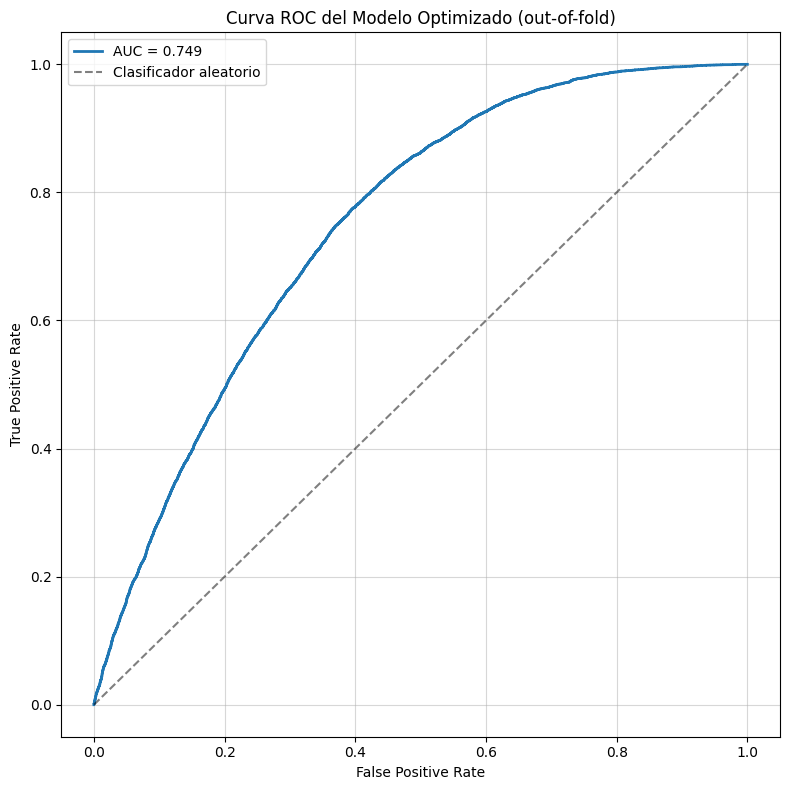

In [32]:
# ============================================================
# Curva ROC del modelo optimizado (predicciones out-of-fold)
# ============================================================

# Cálculo de la curva ROC y el área bajo la curva (AUC)
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8), dpi=100)

plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Clasificador aleatorio")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC del Modelo Optimizado (out-of-fold)")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# ============================================================
# Guardado automático en carpeta "Metricas"
# ============================================================

output_dir = "Metricas"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(
    f"{output_dir}/roc_modelo_optimizado.png",
    dpi=100,
    bbox_inches="tight"
)

plt.show()

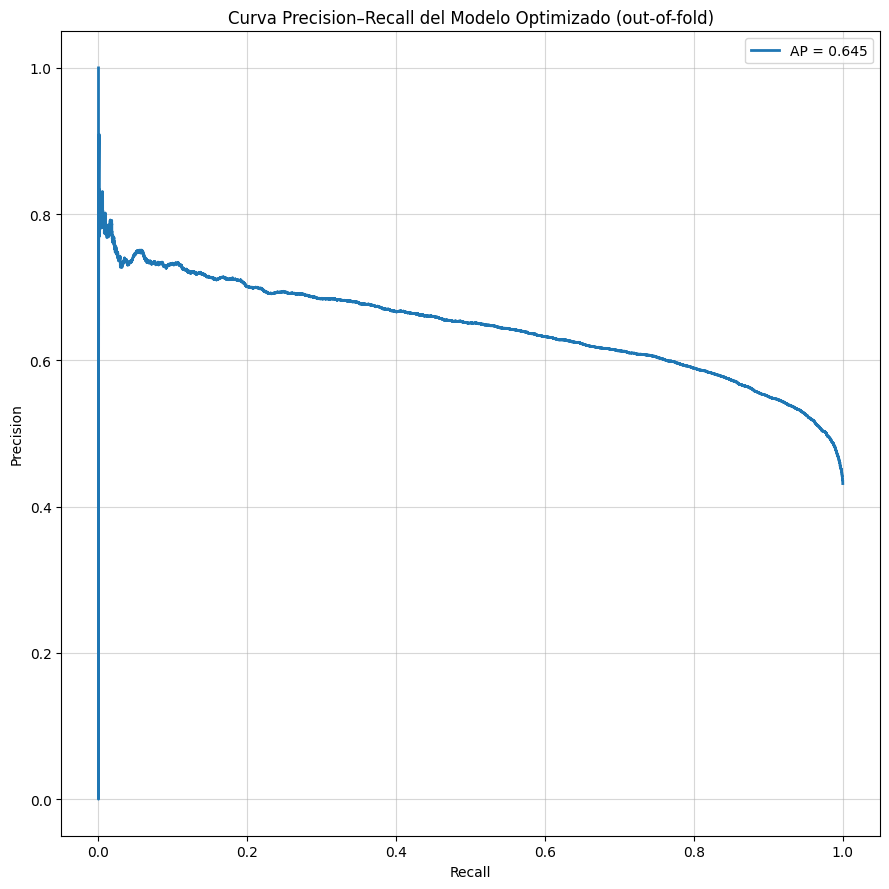

In [36]:
# ============================================================
# Curva Precision–Recall del modelo optimizado (out-of-fold)
# ============================================================

# Cálculo de la curva Precision–Recall y Average Precision (AP)
precision, recall, _ = precision_recall_curve(y, y_proba)
ap = average_precision_score(y, y_proba)

plt.figure(figsize=(9, 9), dpi=100)

plt.plot(
    recall,
    precision,
    linewidth=2,
    label=f"AP = {ap:.3f}"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall del Modelo Optimizado (out-of-fold)")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Guardado automático en carpeta "Metricas"

output_dir = "Metricas"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(
    f"{output_dir}/precision_recall_modelo_optimizado.png",
    dpi=100,
    bbox_inches="tight"
)

plt.show()


<Figure size 900x900 with 0 Axes>

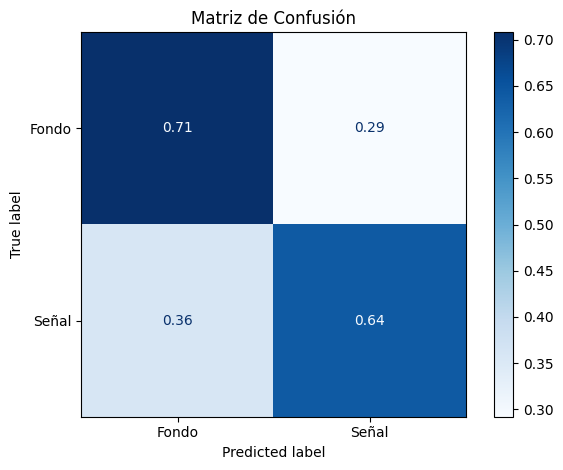

In [39]:
# ============================================================
# Matriz de confusión del modelo optimizado
# Evaluación en un umbral de decisión fijo (threshold = 0.5)
# ============================================================

# Cálculo de la matriz de confusión normalizada por clase verdadera
cm = confusion_matrix(y, y_pred, normalize="true")

plt.figure(figsize=(9, 9), dpi=100)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Fondo", "Señal"]
)

disp.plot(
    cmap="Blues",
    values_format=".2f",
    colorbar=True
)

plt.title("Matriz de Confusión")
plt.tight_layout()


output_dir = "Metricas"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(
    f"{output_dir}/matriz_confusion_modelo_optimizado.png",
    dpi=100,
    bbox_inches="tight"
)

plt.show()

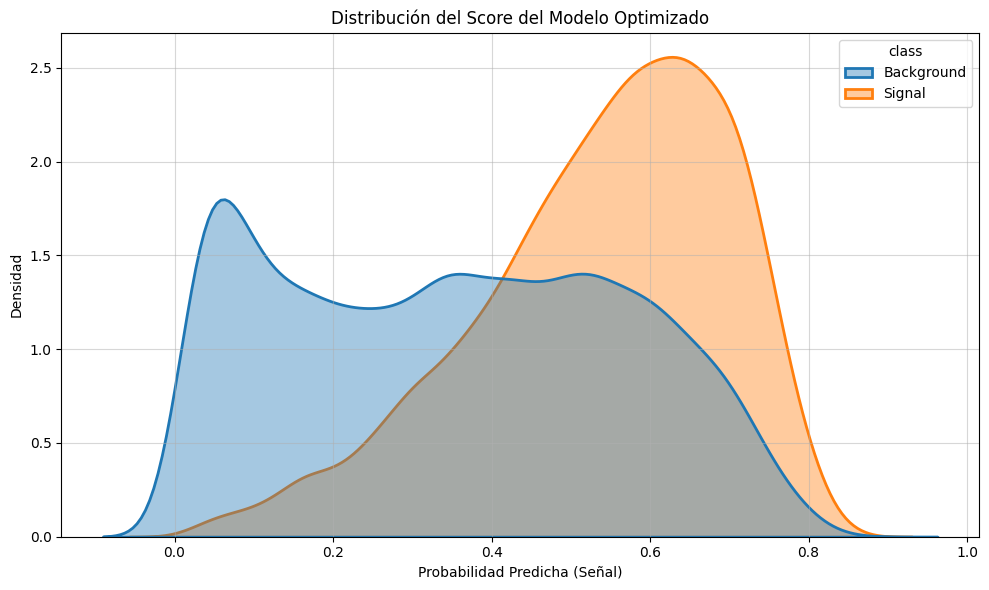

In [45]:
# ============================================================
# Distribución del score del modelo optimizado
# Comparación señal vs fondo (predicciones out-of-fold)
# ============================================================

# DataFrame con scores y etiquetas de clase
df_scores = pd.DataFrame({
    "score": y_proba,
    "class": y.map({0: "Background", 1: "Signal"})
})

plt.figure(figsize=(10, 6), dpi=100)

sns.kdeplot(
    data=df_scores,
    x="score",
    hue="class",
    fill=True,
    common_norm=False,
    alpha=0.4,
    linewidth=2
)

plt.xlabel("Probabilidad Predicha (Señal)")
plt.ylabel("Densidad")
plt.title("Distribución del Score del Modelo Optimizado")
plt.grid(alpha=0.5)
plt.tight_layout()

# ============================================================
# Guardado automático en carpeta "Metricas"
# ============================================================

output_dir = "Metricas"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(
    f"{output_dir}/distribucion_score_modelo_optimizado.png",
    dpi=100,
    bbox_inches="tight"
)

plt.show()

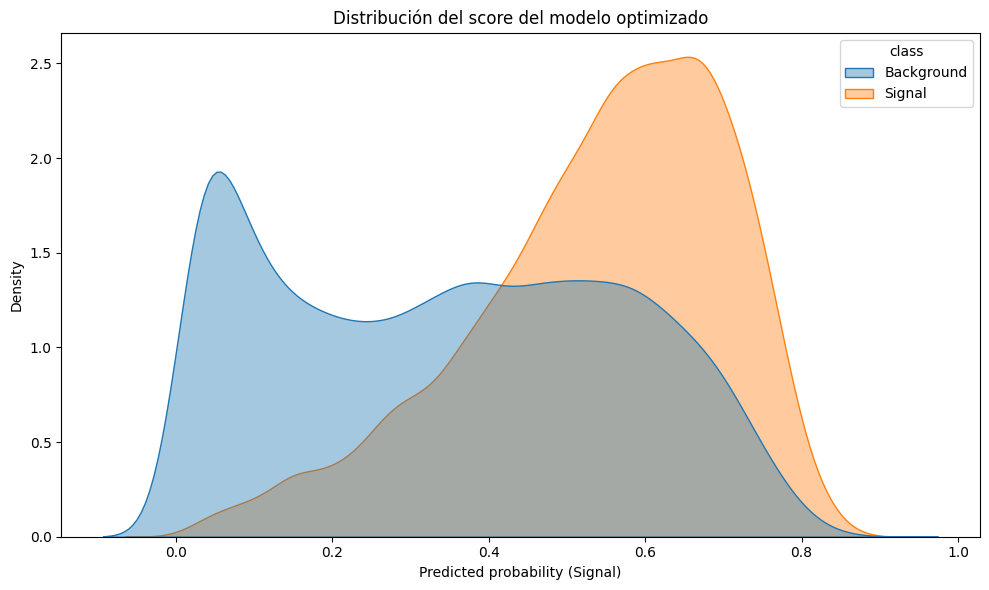

In [129]:
# ============================================================
# Distribución del score del modelo optimizado
# Comparación señal vs fondo (predicciones out-of-fold)
# ============================================================

# DataFrame con scores y etiquetas de clase
df_scores = pd.DataFrame({
    "score": y_proba,
    "class": y.map({0: "Background", 1: "Signal"})
})

# Visualización de la distribución del score por clase
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_scores,
    x="score",
    hue="class",
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.xlabel("Predicted probability (Signal)")
plt.title("Distribución del score del modelo optimizado")
plt.tight_layout()
plt.show()

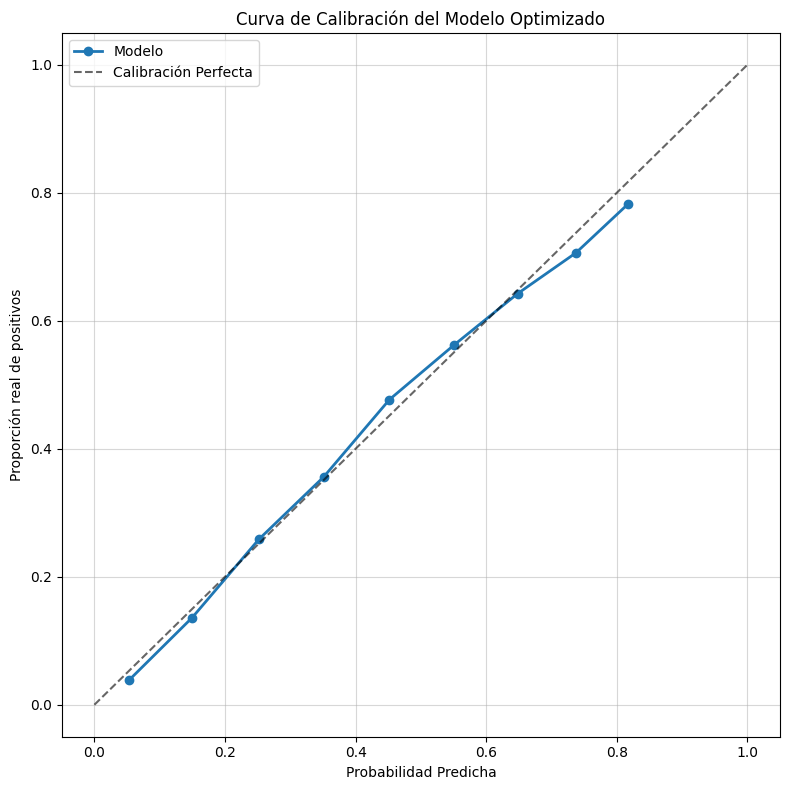

In [48]:
# ============================================================
# Curva de calibración del modelo optimizado
# Evaluación de la calidad probabilística del score
# ============================================================

# Cálculo de la fracción real de positivos vs probabilidad predicha
frac_pos, mean_pred = calibration_curve(
    y,
    y_proba,
    n_bins=10
)

plt.figure(figsize=(8, 8), dpi=100)

plt.plot(
    mean_pred,
    frac_pos,
    marker="o",
    linewidth=2,
    label="Modelo"
)

plt.plot(
    [0, 1],
    [0, 1],
    "k--",
    alpha=0.6,
    label="Calibración Perfecta"
)

plt.xlabel("Probabilidad Predicha")
plt.ylabel("Proporción real de positivos")
plt.title("Curva de Calibración del Modelo Optimizado")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# ============================================================
# Guardado automático en carpeta "Metricas"
# ============================================================

output_dir = "Metricas"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(
    f"{output_dir}/calibracion_modelo_optimizado.png",
    dpi=100,
    bbox_inches="tight"
)

plt.show()

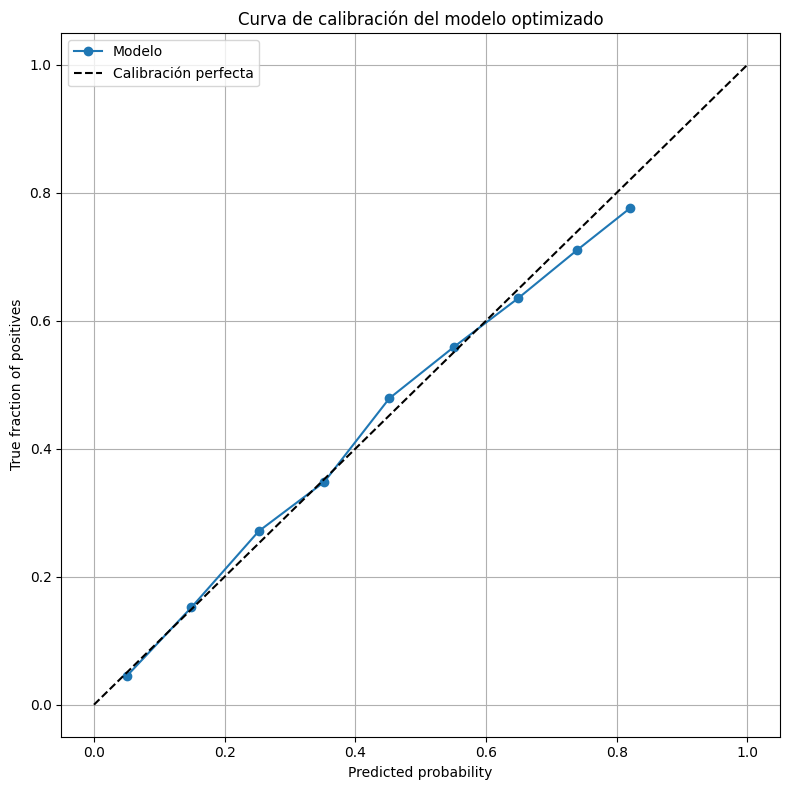


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [137]:
# ============================================================
# Curva de calibración del modelo optimizado
# Evaluación de la calidad probabilística del score
# ============================================================

# Cálculo de la fracción real de positivos vs probabilidad predicha
frac_pos, mean_pred = calibration_curve(
    y,
    y_proba,
    n_bins=10
)

# Visualización de la curva de calibración
plt.figure(figsize=(8, 8), dpi=100)
plt.plot(mean_pred, frac_pos, marker="o", label="Modelo")
plt.plot([0, 1], [0, 1], "k--", label="Calibración perfecta")

plt.xlabel("Predicted probability")
plt.ylabel("True fraction of positives")
plt.title("Curva de calibración del modelo optimizado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
